In [1]:
import torch
import tqdm

import numpy  as np
import pandas as pd
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from math  import comb
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import Lasso

from torchdiffeq import odeint

from utils import POS, REF_NET, highlight_edges

import warnings
warnings.filterwarnings("ignore", category = UserWarning)

np.set_printoptions(precision = 3, suppress = True)

df = pd.read_csv('data.csv', index_col = 0)
df.head()

SWI5    CBF1    GAL4   GAL80    ASH1
time                                        
0     0.0760  0.0419  0.0207  0.0225  0.1033
10    0.0186  0.0365  0.0122  0.0175  0.0462
20    0.0090  0.0514  0.0073  0.0165  0.0439
30    0.0117  0.0473  0.0079  0.0147  0.0371
40    0.0088  0.0482  0.0084  0.0145  0.0475

### Non-torch implementation

In [2]:
trainData = df.iloc[ ::2, :].to_numpy()
testData  = df.iloc[1::2, :].to_numpy() # time-points x p

In [3]:
def estimateGradients(data, timePoints, smoothing: float = 1e-5):
    splines = []
    D = data.shape[1]
    gradients = np.zeros((timePoints.shape[0], D))

    for d in range(D):
        spline = UnivariateSpline(timePoints, data[:, d], s = smoothing)
        splines.append(spline)
        gradients[:, d] = spline.derivative()(timePoints)

    return gradients, splines

def makeLibrary(X, dim = 1) -> np.ndarray:
    n, D = X.shape
    if dim == 1:
        return X
    elif dim == 2:
        lib = [X]
        for i in range(D):
            for j in range(i, D):
                lib.append((X[:, i] * X[:, j]).reshape(-1, 1))
        return np.hstack(lib)
    else:
        print("Nothing implemented for dim > 2")
        return np.array([])

_, D = df.shape
dim    = 2

# grads, splines = estimateGradients(trainData, df.index.values[::2])
# library        = makeLibrary(trainData, dim = dim)
# gradMatrix     = np.random.rand(library.shape[1], D)
# Linear(in_features = p, out_features = D, bias = False)

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
Required step size is less than spacing between numbers.


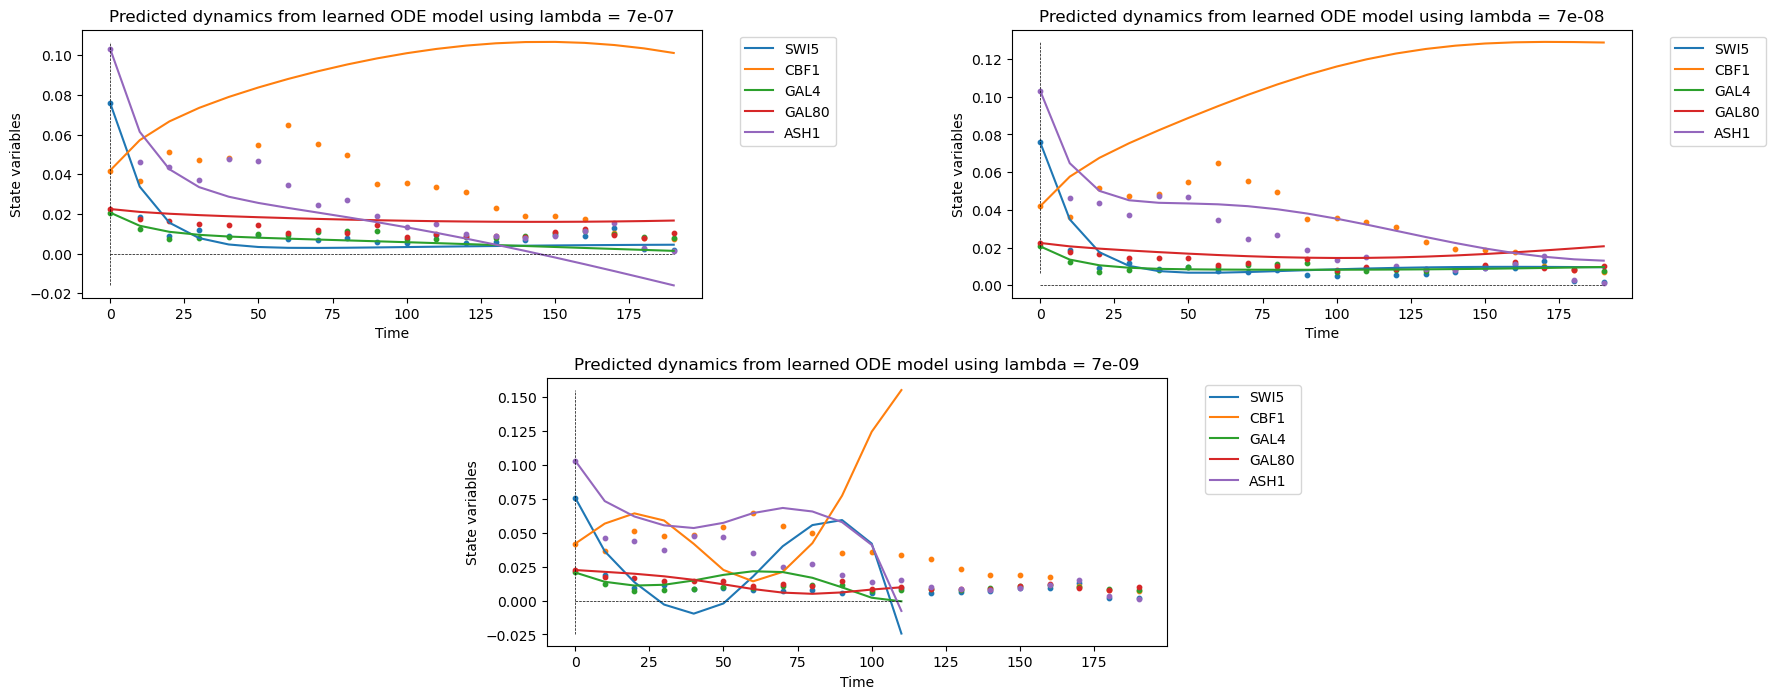

In [31]:
grads, splines = estimateGradients(trainData, df.index.values[::2])
library        = makeLibrary(trainData, dim = dim)
gradMatrix     = np.random.rand(library.shape[1], D)

alphas = [7e-7, 7e-8, 7e-9]

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 4, hspace = 0.3, wspace = 2)
ax = [
    fig.add_subplot(gs[0, :2]),   # Top left
    fig.add_subplot(gs[0, 2:]),   # Top right
    fig.add_subplot(gs[1, 1:3])   # Bottom center
]

for i, alpha in enumerate(alphas):
    for d in range(D):
        lasso = Lasso(alpha = alpha, max_iter = 10000)
        lasso.fit(library, grads[:, d])
        gradMatrix[:, d] = lasso.coef_


    # prediction 
    def fun(t, x):
        libX = makeLibrary(x.reshape(1, -1), dim = dim)
        dxdt = libX @ gradMatrix
        return dxdt.flatten()


    out = solve_ivp(
        fun = fun,
        t_span = (df.index.values[0], df.index.values[-1]),
        y0 = df.iloc[0, :].to_numpy(),
        t_eval = df.index.values,

    )

    # Plot solution all one one plot using seaborn
    X_out = out.y.T
    
    print(out.message)
    df_out = pd.DataFrame(X_out, index = out.t, columns = df.columns)
    df_out_long = df_out.reset_index().melt(id_vars = 'index')
    sns.lineplot(data = df_out_long, x = 'index', y = 'value', hue = 'variable', ax = ax[i])
    # plot the axis
    ax[i].hlines(y = 0, xmin = out.t[0], xmax = out.t[-1], color = 'k', linestyle = '--', linewidth = 0.5)
    ax[i].vlines(x = 0, ymin = df_out_long['value'].min(), ymax = df_out_long['value'].max(), color = 'k', linestyle = '--', linewidth = 0.5)
    ax[i].set_title(f'Predicted dynamics from learned ODE model using lambda = {alpha}')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('State variables')
    ax[i].legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    # scatter the original data points
    for d in df.columns:
        ax[i].scatter(df.index.values, df[d].values, s = 10)

plt.show()

In [13]:
gradMatrix

array([[-0.08 ,  0.003, -0.012, -0.   , -0.081],
       [ 0.003, -0.   ,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   ,  0.   ],
       [-0.003,  0.017, -0.   , -0.002, -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [ 0.   , -0.   ,  0.   , -0.   , -0.   ],
       [ 0.   , -0.   , -0.   , -0.   , -0.   ],
       [-0.   , -0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   ,  0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.   ,  0.   , -0.   , -0.   , -0.   ]])

Fitting with alpha = 0.0
coeffieicnt alpha = 0.0 doesn't reach the end; 2 skipping plot

Fitting with alpha = 1e-10
coeffieicnt alpha = 1e-10 doesn't reach the end; 2 skipping plot

Fitting with alpha = 2e-10
coeffieicnt alpha = 2e-10 doesn't reach the end; 2 skipping plot

Fitting with alpha = 3e-10
coeffieicnt alpha = 3e-10 doesn't reach the end; 2 skipping plot

Fitting with alpha = 4e-10
coeffieicnt alpha = 4e-10 doesn't reach the end; 2 skipping plot

Fitting with alpha = 5e-10
Skipping due to long computation time

Fitting with alpha = 6e-10
Skipping due to long computation time

Fitting with alpha = 7.000000000000001e-10
Skipping due to long computation time

Fitting with alpha = 8e-10
coeffieicnt alpha = 8e-10 doesn't reach the end; 3 skipping plot

Fitting with alpha = 9e-10
coeffieicnt alpha = 9e-10 doesn't reach the end; 3 skipping plot

Fitting with alpha = 0.0
coeffieicnt alpha = 0.0 doesn't reach the end; 2 skipping plot

Fitting with alpha = 1e-09
coeffieicnt alpha = 1e-

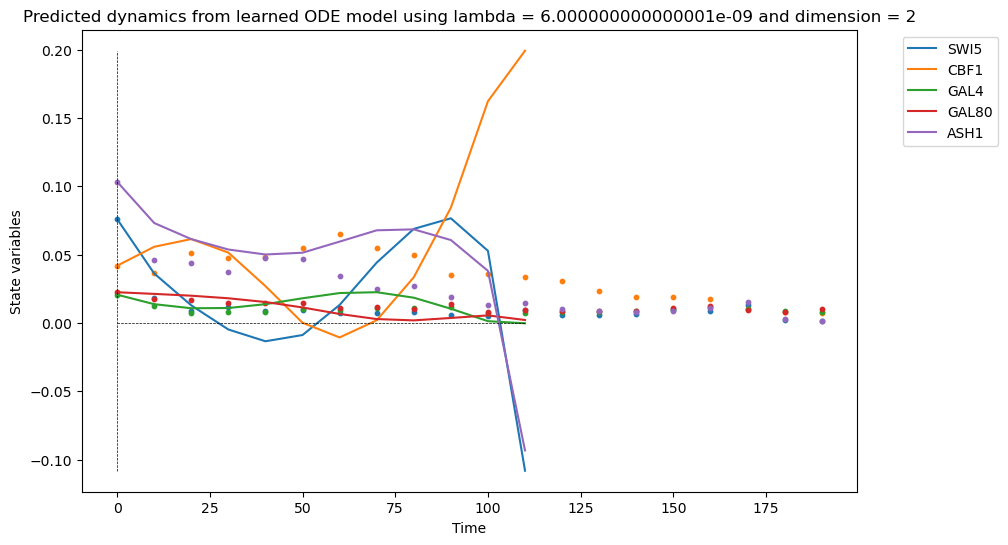

Fitting with alpha = 7.000000000000001e-09


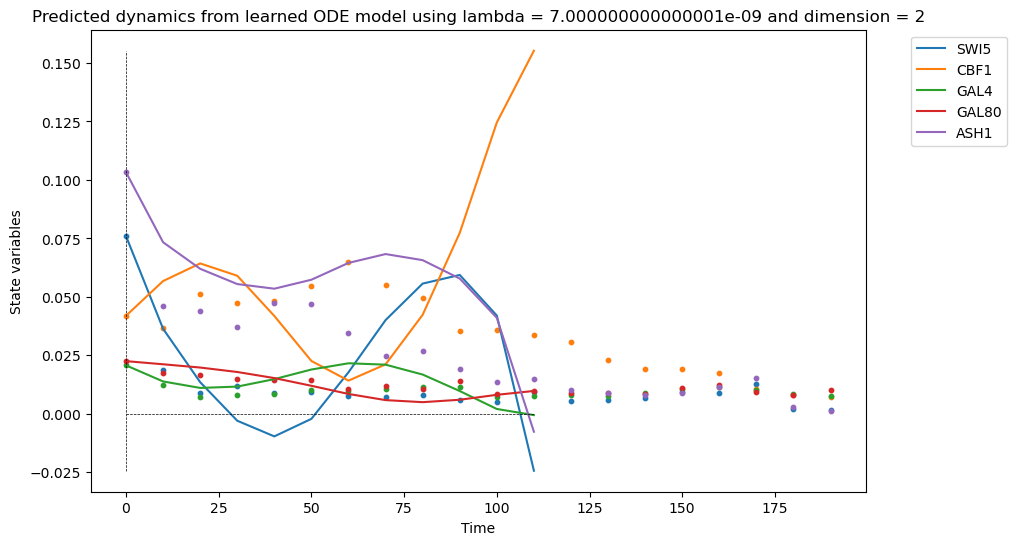

Fitting with alpha = 8e-09


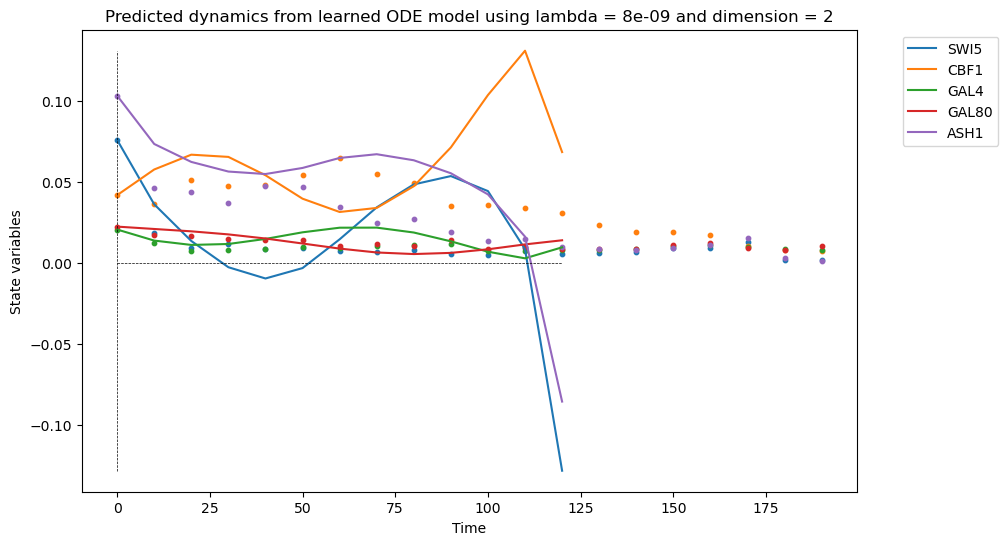

Fitting with alpha = 9.000000000000001e-09


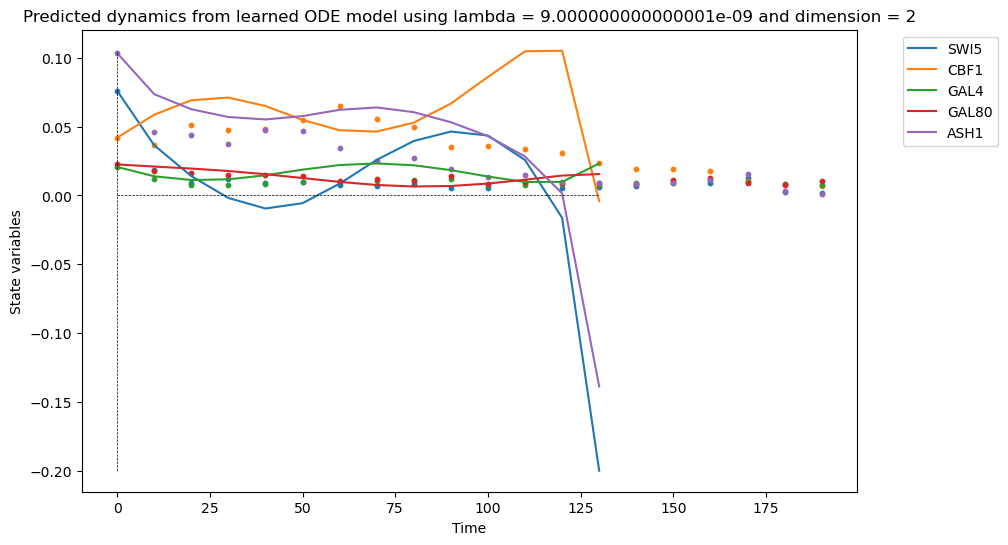

Fitting with alpha = 0.0
coeffieicnt alpha = 0.0 doesn't reach the end; 2 skipping plot

Fitting with alpha = 1e-08


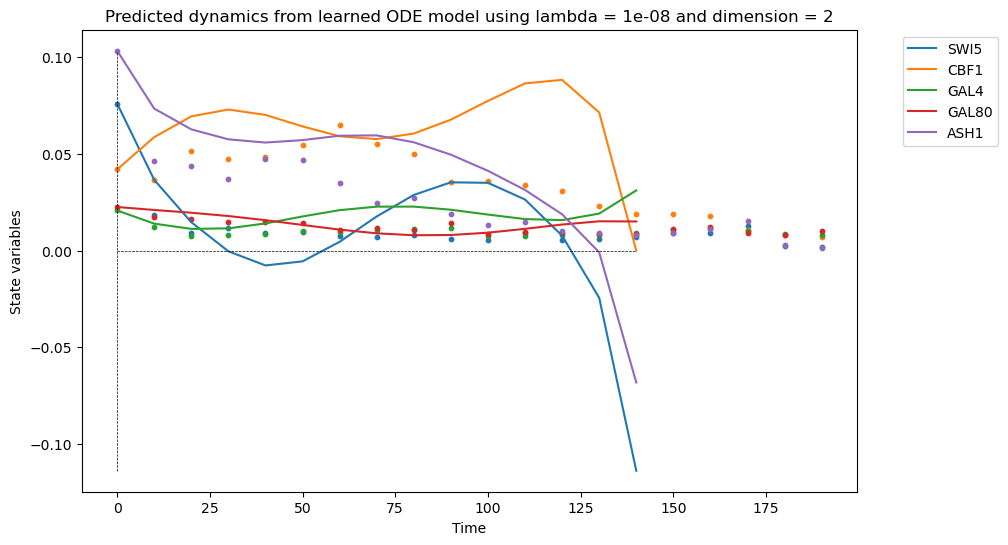

Fitting with alpha = 2e-08


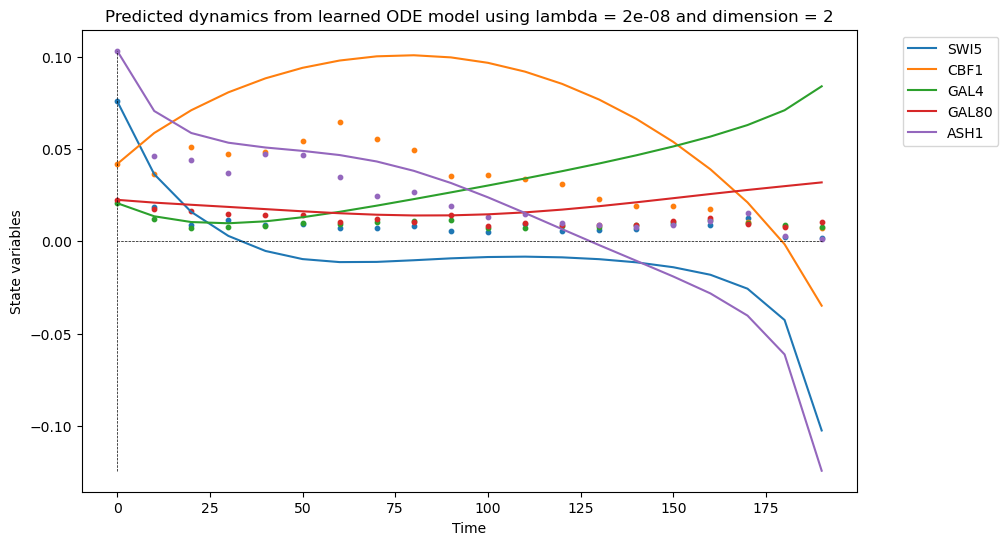

Fitting with alpha = 3.0000000000000004e-08


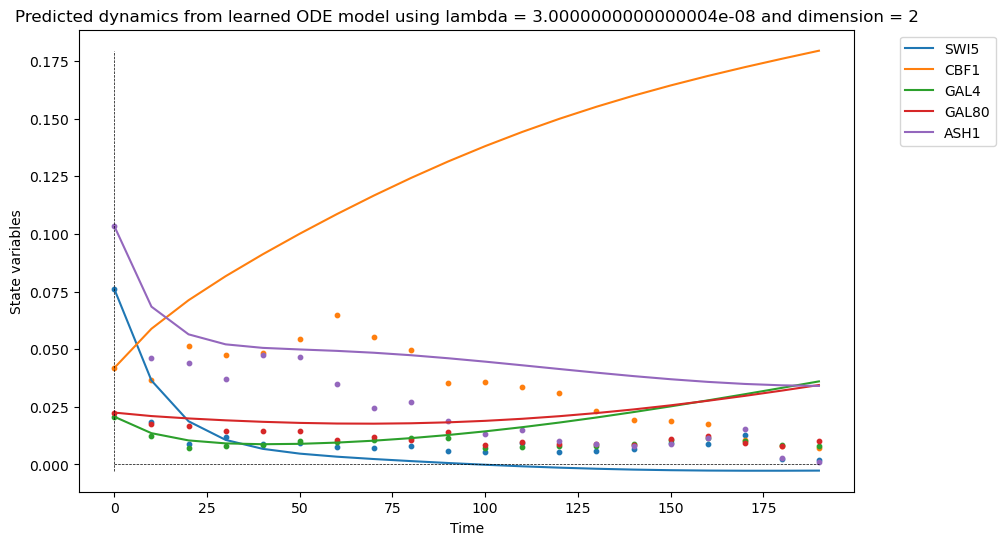

Fitting with alpha = 4e-08


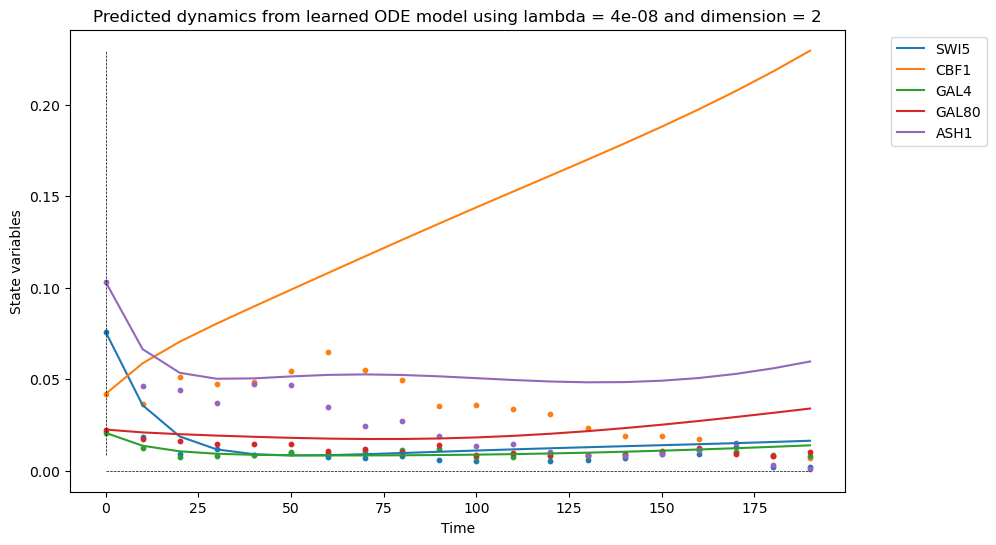

Fitting with alpha = 5e-08


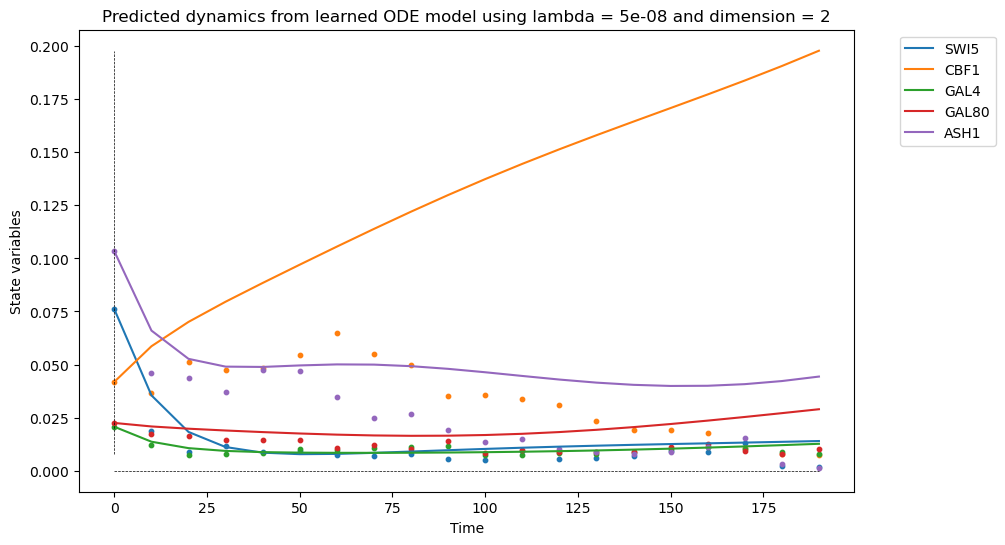

Fitting with alpha = 6.000000000000001e-08


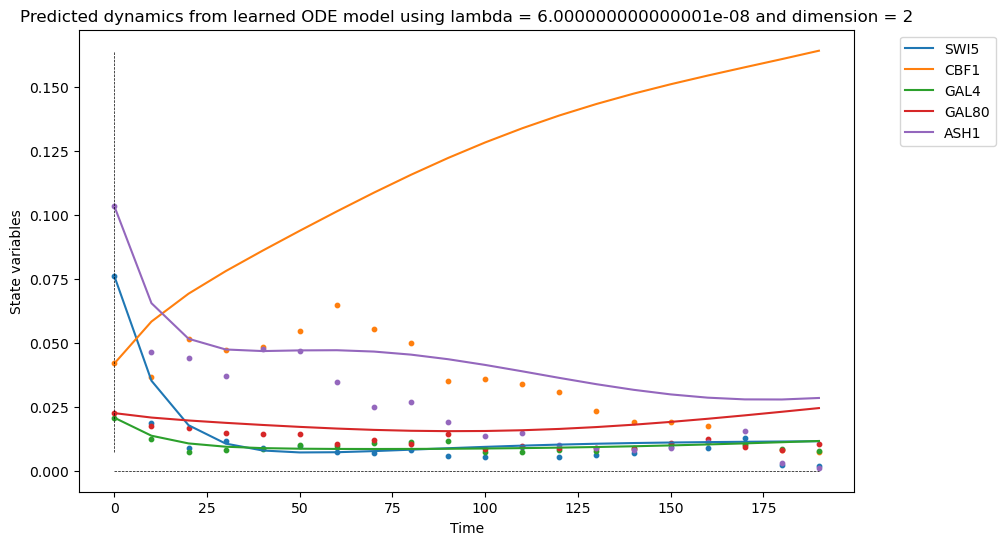

Fitting with alpha = 7e-08


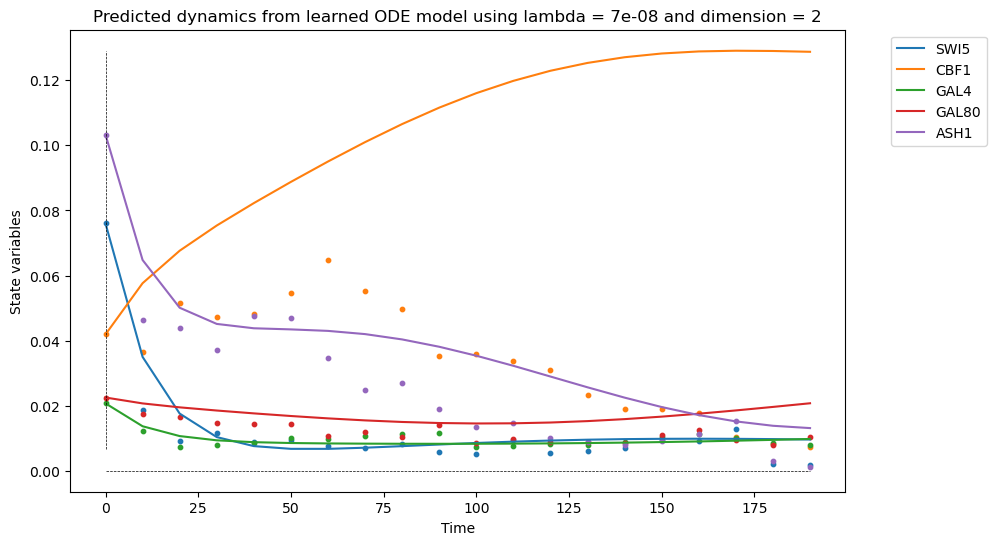

Fitting with alpha = 8e-08


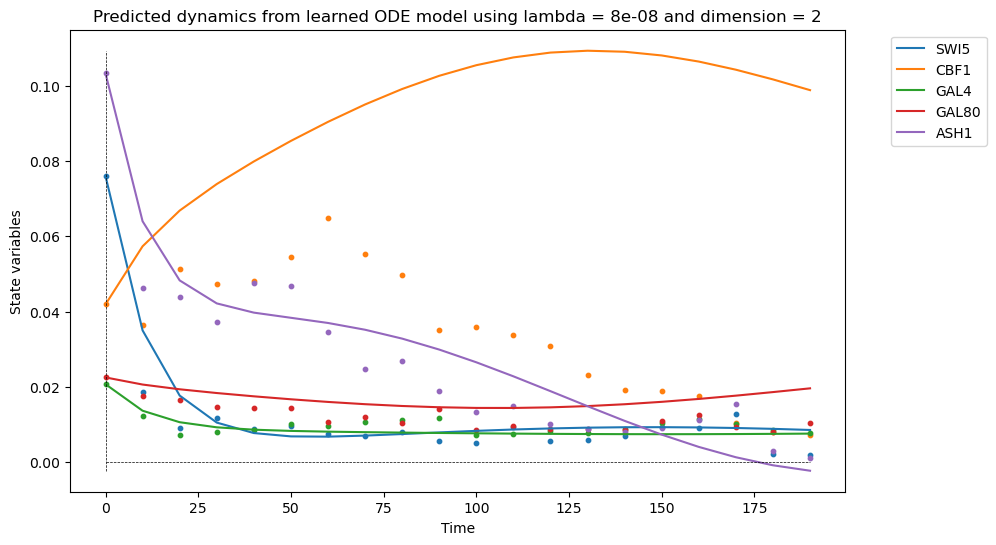

Fitting with alpha = 9e-08


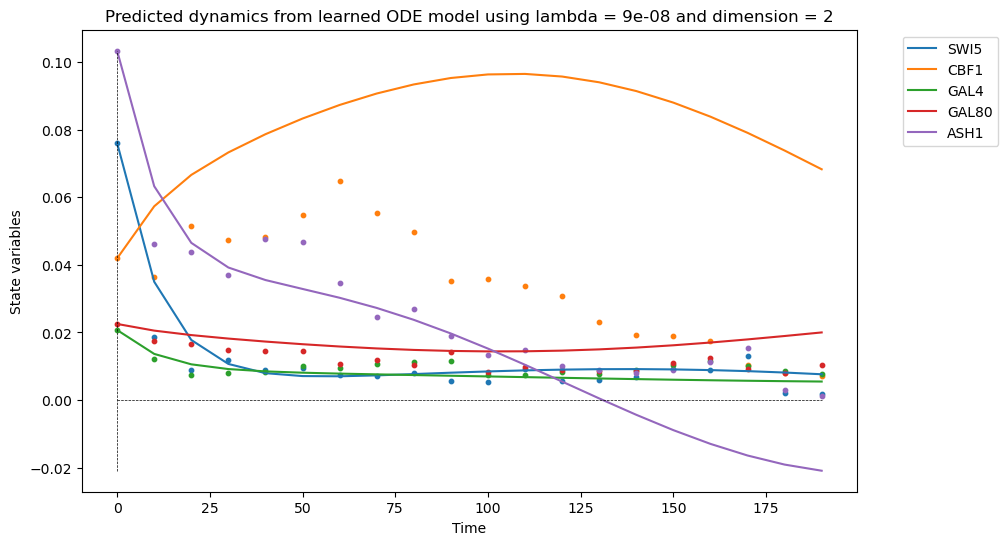

Fitting with alpha = 0.0
coeffieicnt alpha = 0.0 doesn't reach the end; 2 skipping plot

Fitting with alpha = 1e-07


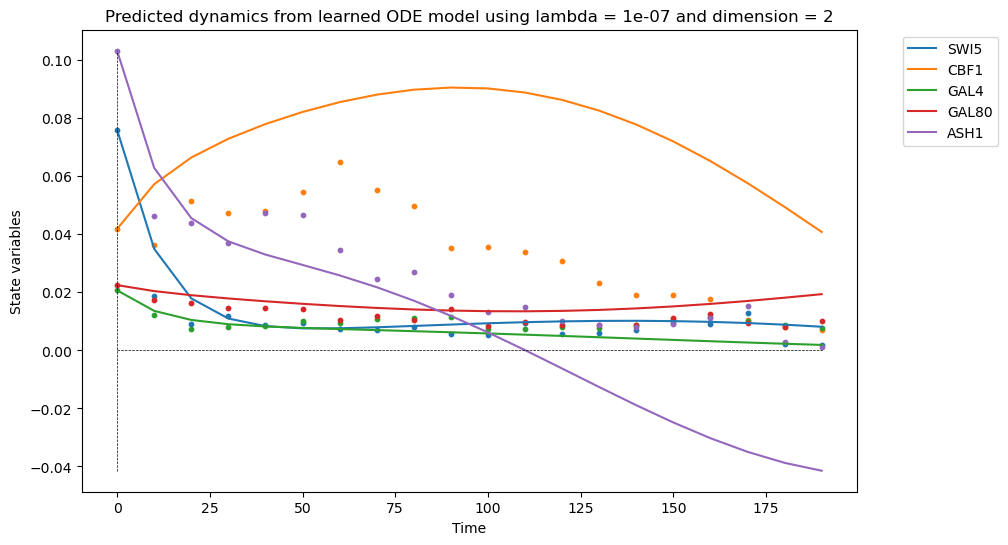

Fitting with alpha = 2e-07


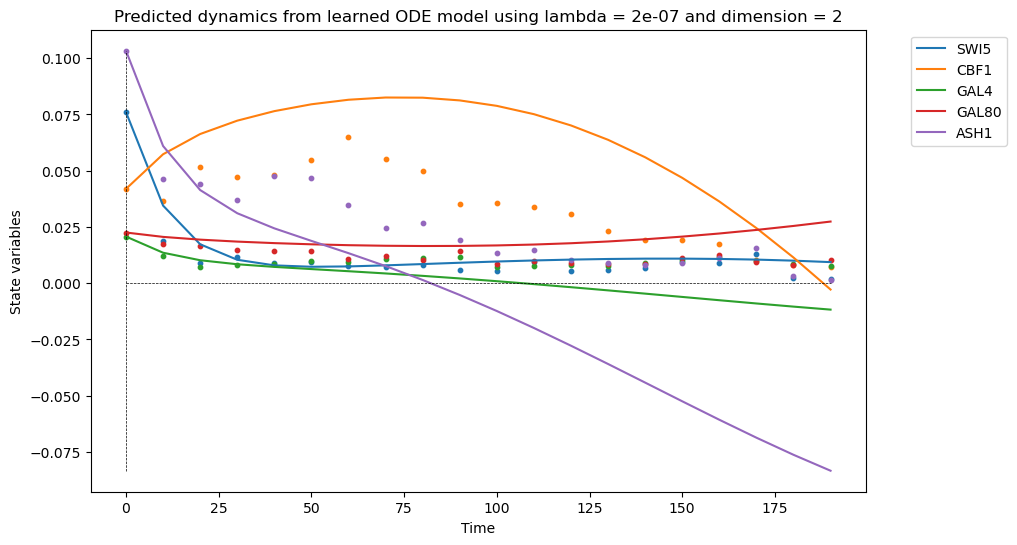

Fitting with alpha = 3e-07


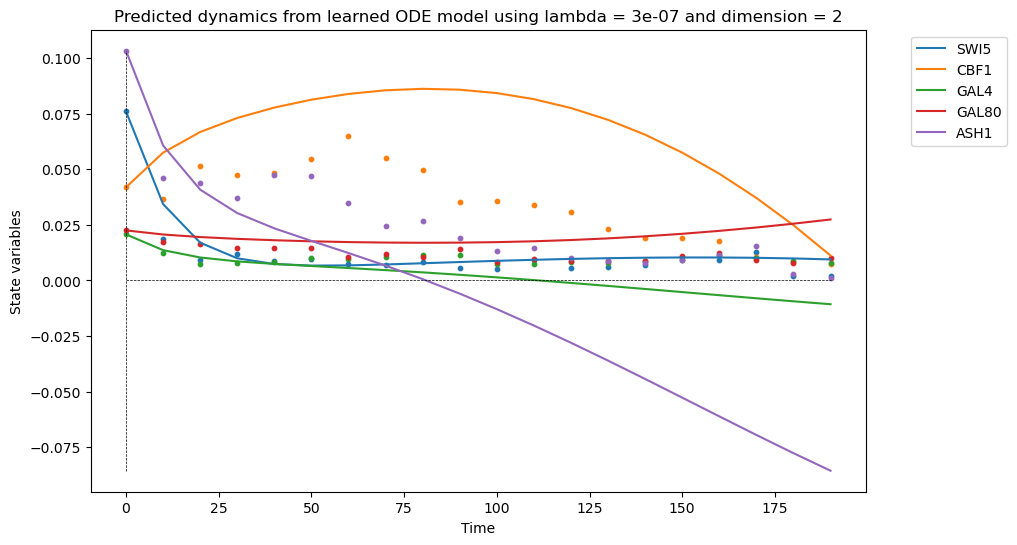

Fitting with alpha = 4e-07


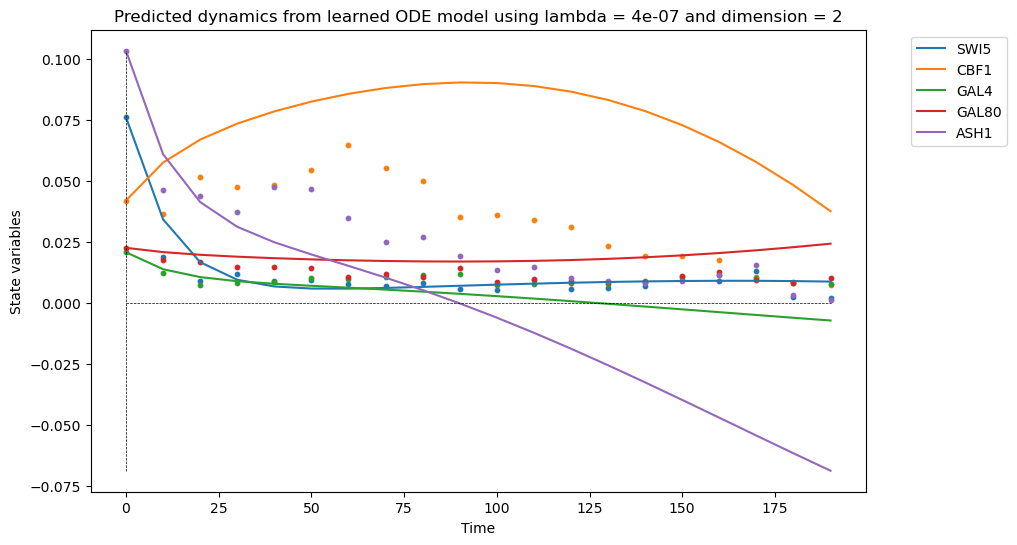

Fitting with alpha = 5e-07


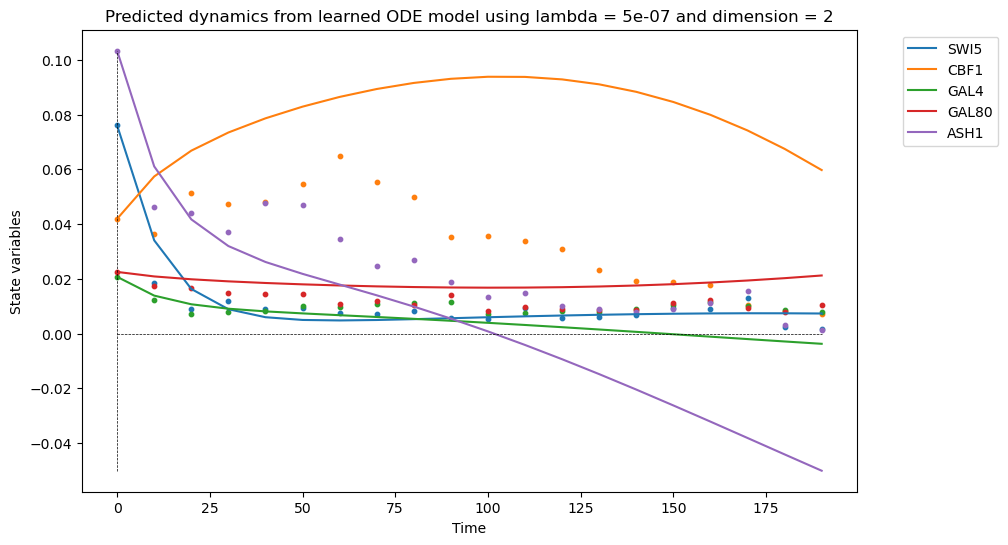

Fitting with alpha = 6e-07


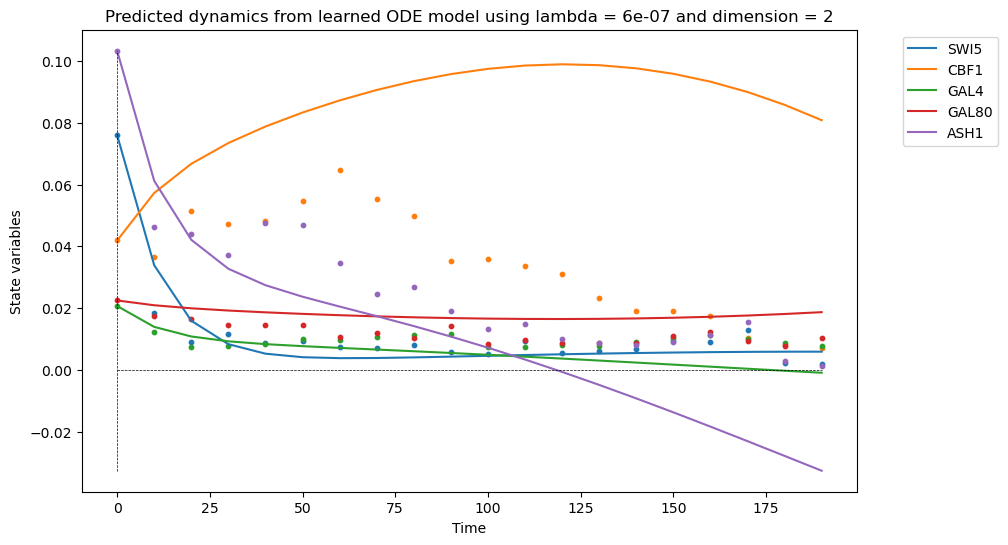

Fitting with alpha = 7e-07


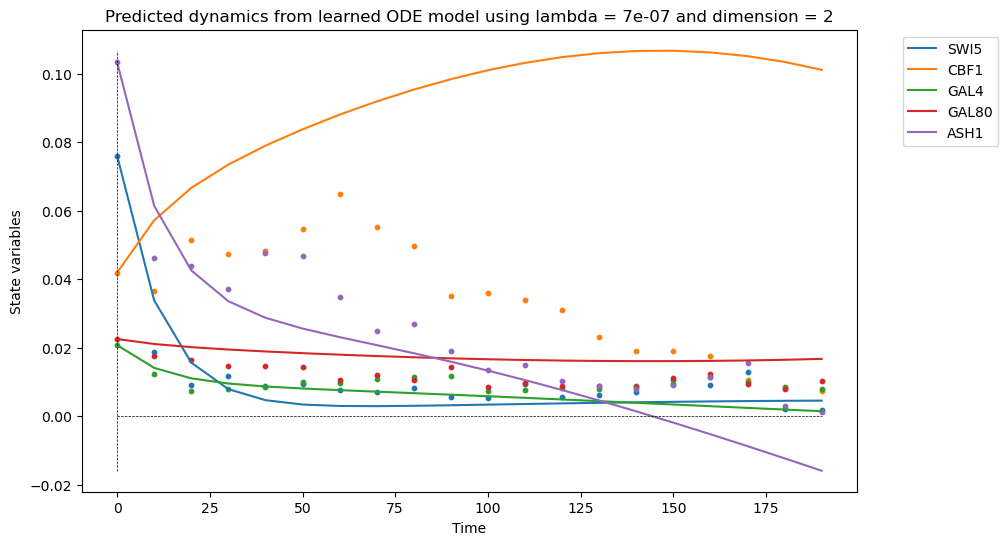

Fitting with alpha = 8e-07


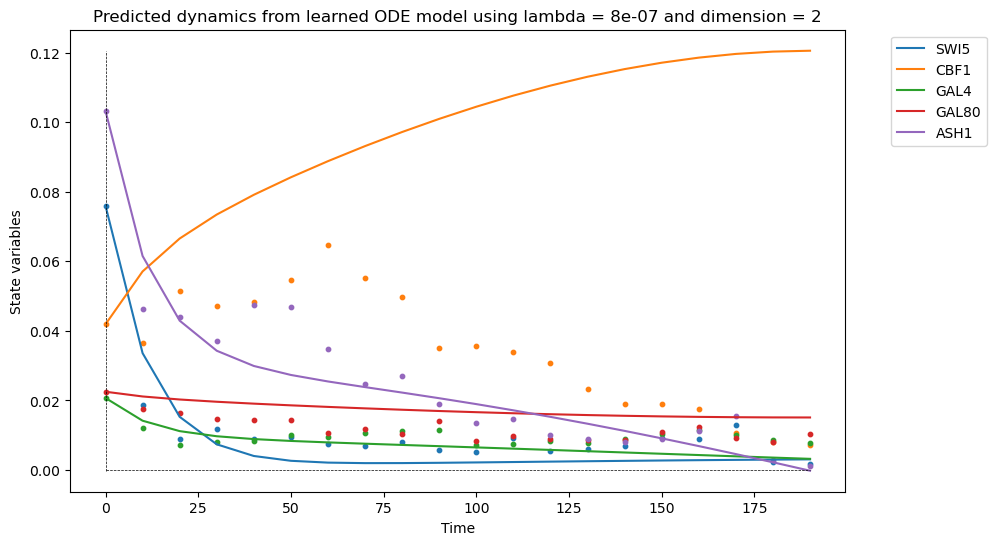

Fitting with alpha = 9e-07


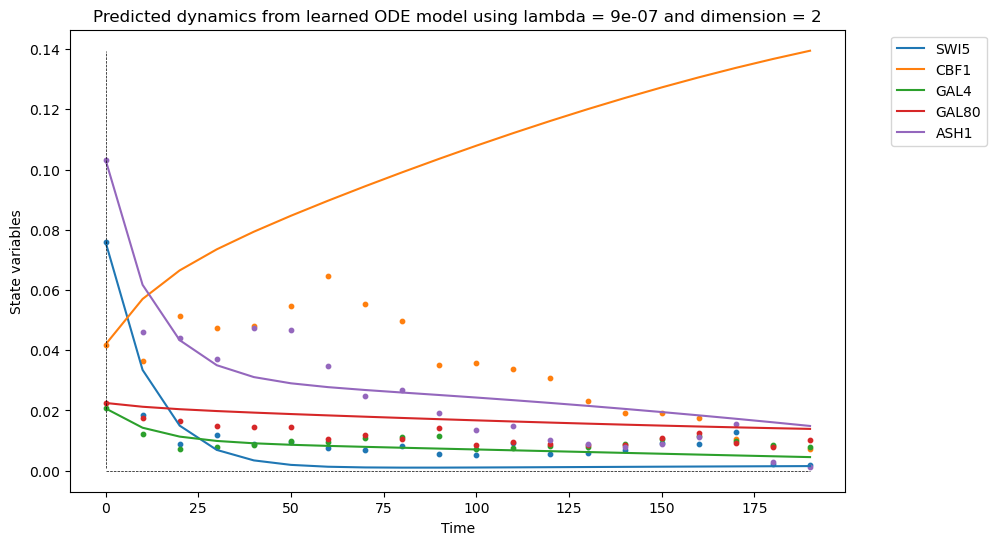

Fitting with alpha = 0.0
coeffieicnt alpha = 0.0 doesn't reach the end; 2 skipping plot

Fitting with alpha = 1e-06


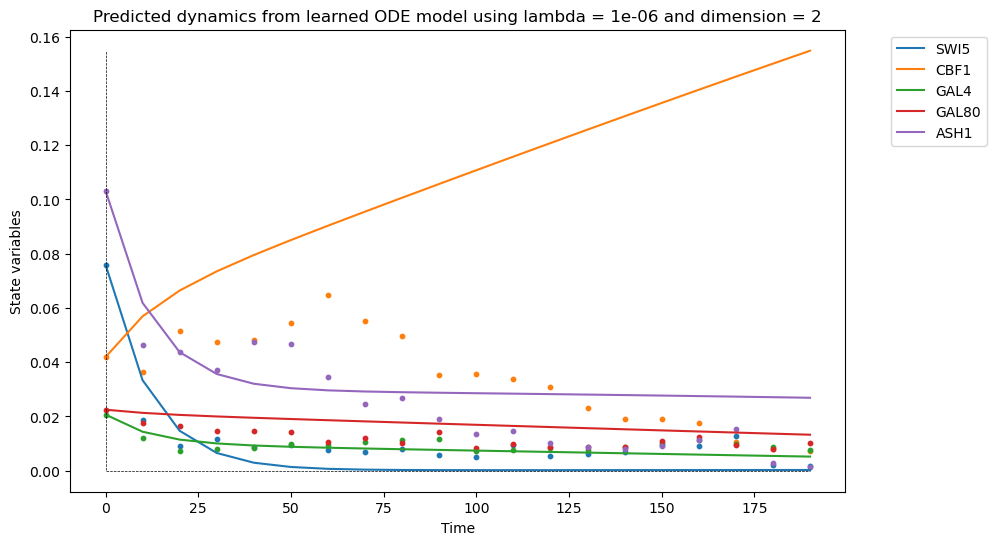

Fitting with alpha = 2e-06


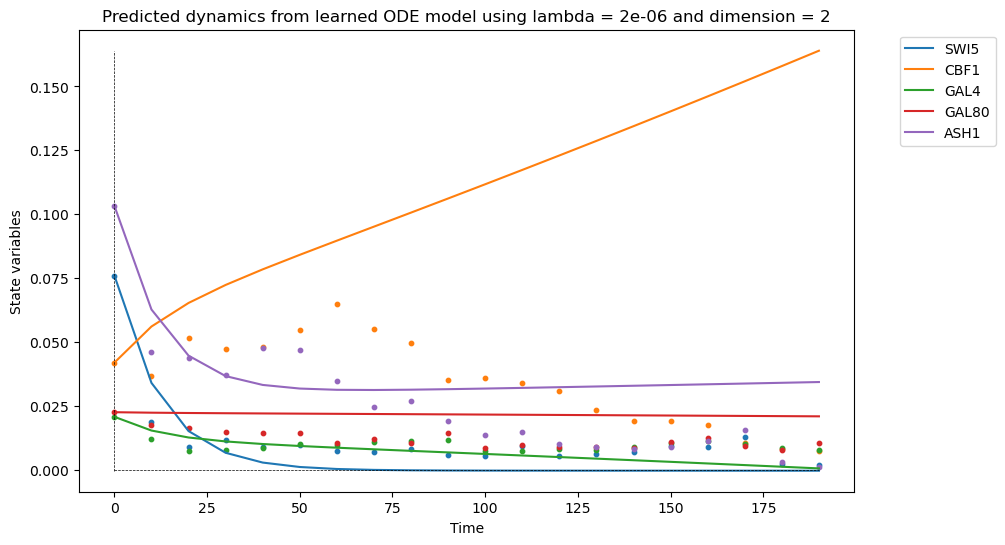

Fitting with alpha = 3e-06


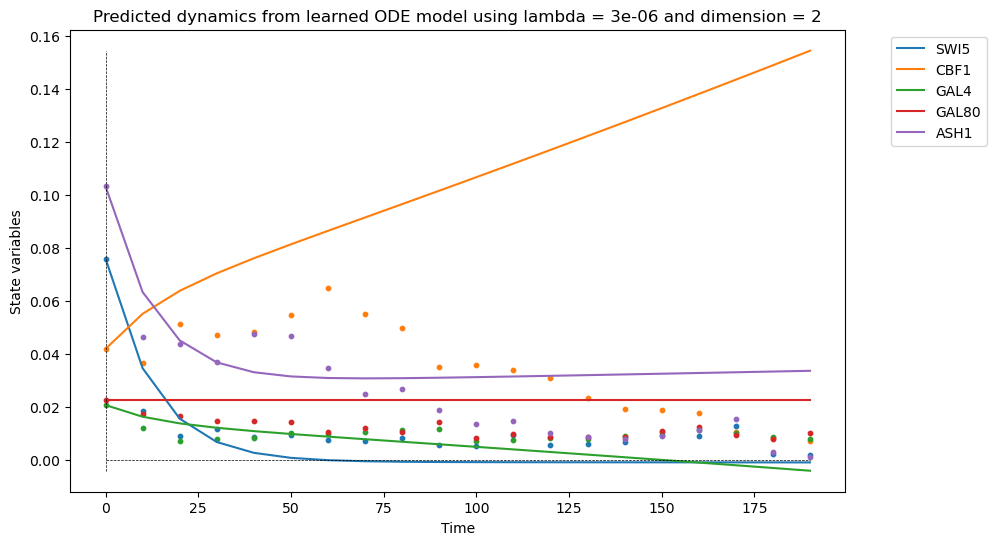

Fitting with alpha = 4e-06


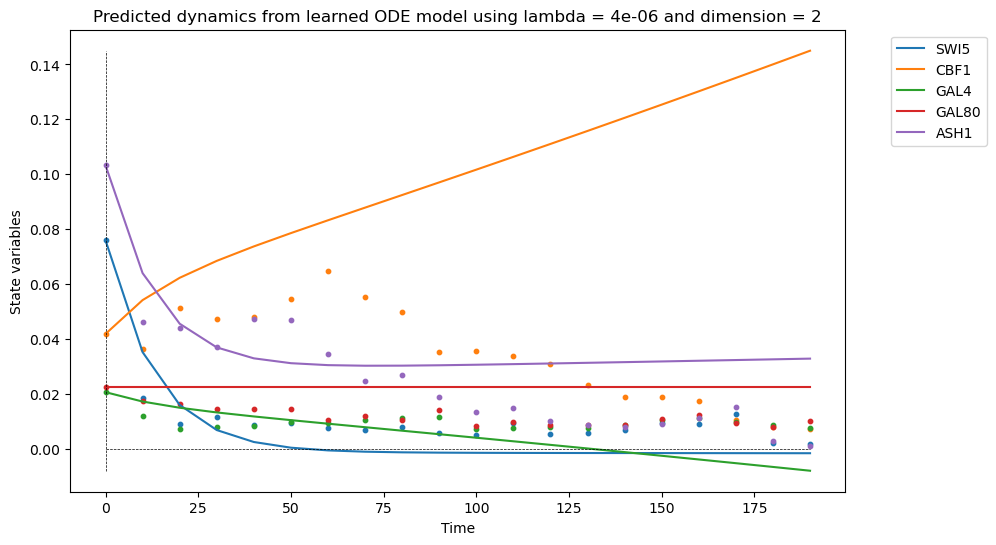

Fitting with alpha = 4.9999999999999996e-06


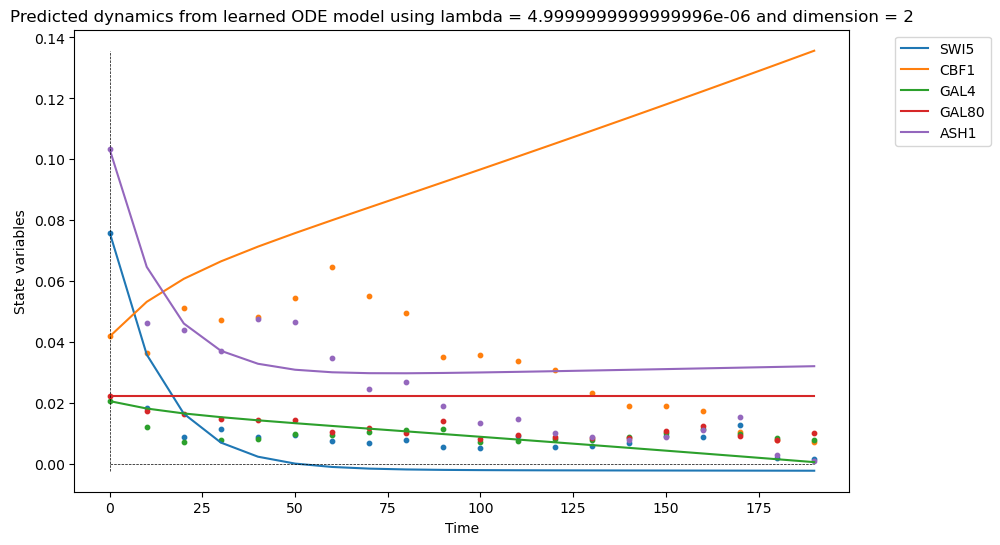

Fitting with alpha = 6e-06


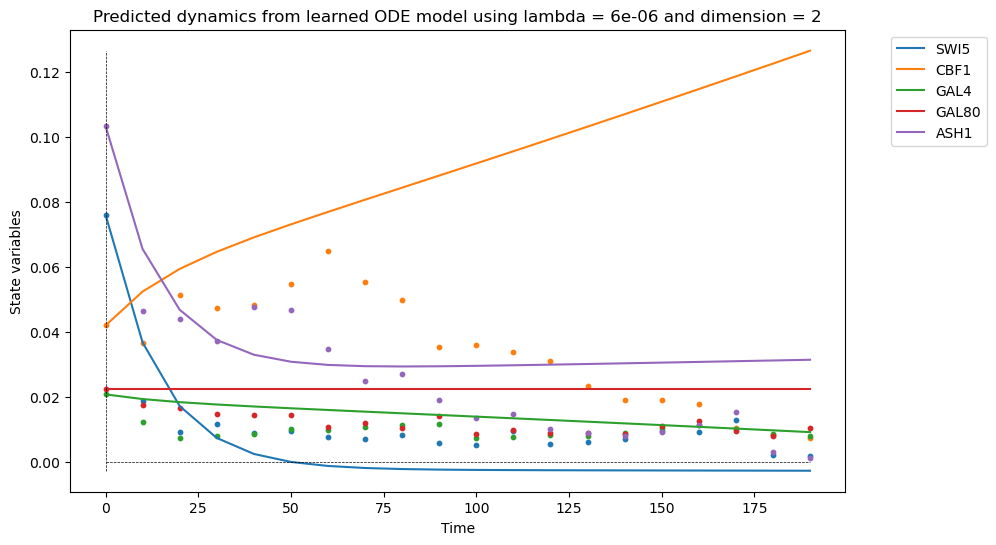

Fitting with alpha = 7e-06


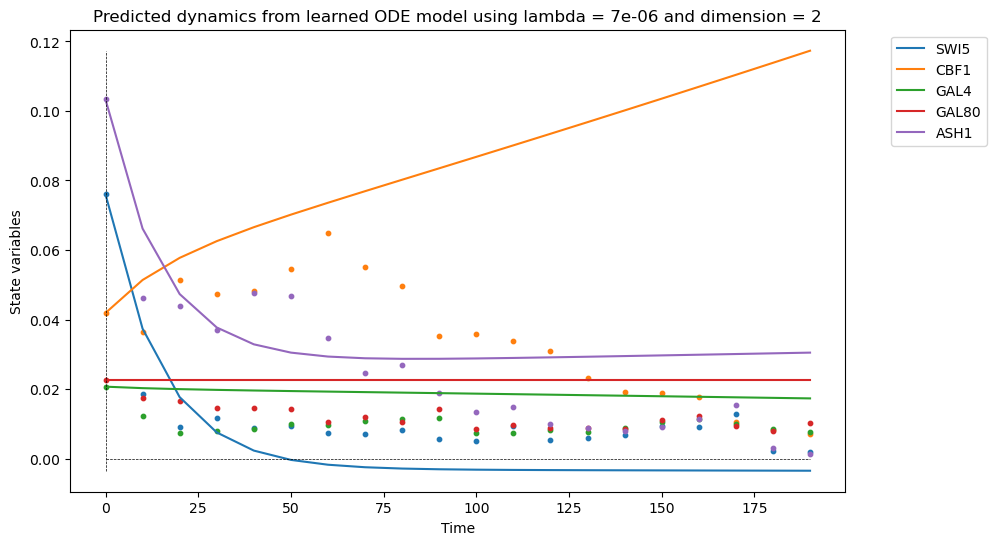

Fitting with alpha = 8e-06


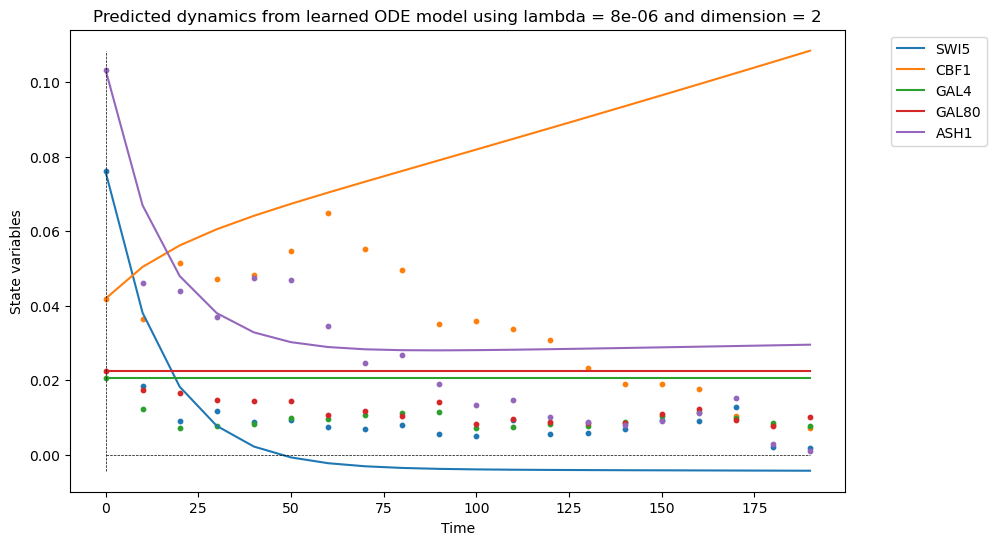

Fitting with alpha = 9e-06


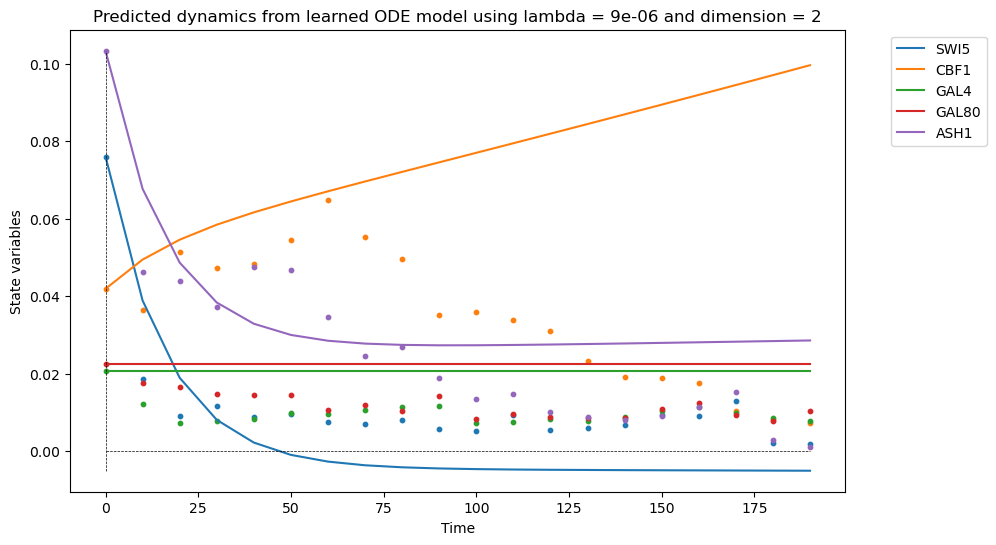

In [17]:
for exp in [-10, -9, -8, -7, -6]:
    for coef in range(10):
        grads, splines = estimateGradients(trainData, df.index.values[::2])
        library        = makeLibrary(trainData, dim = dim)
        gradMatrix     = np.random.rand(library.shape[1], D)

        alpha = coef * 10 ** (exp)
        print(f"Fitting with alpha = {alpha}")
        if (exp == -10) and (coef in [5, 6, 7]):
            print("Skipping due to long computation time\n") # the algorithms gets stuck in with the fitting - i stopped it after 45mins.
            continue

        for d in range(D):
            lasso = Lasso(alpha = alpha, max_iter = 10000)
            lasso.fit(library, grads[:, d])
            gradMatrix[:, d] = lasso.coef_


        # prediction 
        def fun(t, x):
            libX = makeLibrary(x.reshape(1, -1), dim = dim)
            dxdt = libX @ gradMatrix
            return dxdt.flatten()


        out = solve_ivp(
            fun = fun,
            t_span = (df.index.values[0], df.index.values[-1]),
            y0 = df.iloc[0, :].to_numpy(),
            t_eval = df.index.values,

        )

        # Plot solution all one one plot using seaborn
        X_out = out.y.T
        if out.t.size < 10:
            print(f"coeffieicnt alpha = {alpha} doesn't reach the end; {out.t.size} skipping plot\n")
            continue
        df_out = pd.DataFrame(X_out, index = out.t, columns = df.columns)
        df_out_long = df_out.reset_index().melt(id_vars = 'index')
        plt.figure(figsize = (10, 6))
        sns.lineplot(data = df_out_long, x = 'index', y = 'value', hue = 'variable')
        # plot the axis
        plt.hlines(y = 0, xmin = out.t[0], xmax = out.t[-1], color = 'k', linestyle = '--', linewidth = 0.5)
        plt.vlines(x = 0, ymin = df_out_long['value'].min(), ymax = df_out_long['value'].max(), color = 'k', linestyle = '--', linewidth = 0.5)
        plt.title(f'Predicted dynamics from learned ODE model using lambda = {alpha} and dimension = {dim}')
        plt.xlabel('Time')
        plt.ylabel('State variables')
        plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
        # scatter the original data points
        for d in df.columns:
            plt.scatter(df.index.values, df[d].values, s = 10)

        plt.show()

### Torch

In [38]:
class ODE(nn.Module):
    def __init__(self, D, dim, init_zeros = True):
        super(ODE, self).__init__()
        self.dim = dim
        self.p = comb(D + dim, dim) - 1
        self.D = D
        
        # list of the library terms corresponding to variable names
        varNames = df.columns.tolist()
        # up to dim = 3
        libTerms = varNames.copy()
        for i in range(len(varNames)):
            libTerms.append(f"{varNames[i]}^2")
            for j in range(i + 1, len(varNames)):
                libTerms.append(f"{varNames[i]} * {varNames[j]}")

        for i in range(len(varNames)):
            for j in range(i, len(varNames)):
                for k in range(j, len(varNames)):
                    libTerms.append(f"{varNames[i]} * {varNames[j]} * {varNames[k]}")

        self.libTerms = np.array(libTerms)
        self.varNames = np.array(varNames)
        del varNames, libTerms
        
        self.linear = nn.Linear(self.p, D, bias = False)
        if init_zeros:
            nn.init.zeros_(self.linear.weight)


    def _makeLibraryDim(self, X, dimInd):
        # NO IMPLEMENTATION FOR DIM > 3
        _, D = X.shape
        if dimInd == 1:
            return X
        elif dimInd == 2:
            products = X.unsqueeze(2) * X.unsqueeze(1)
            idx      = torch.triu_indices(D, D)
            pairwise = products[:, idx[0], idx[1]]
            
            return pairwise
        elif dimInd == 3:
            x1 = X.unsqueeze(2).unsqueeze(3)
            x2 = X.unsqueeze(1).unsqueeze(3)
            x3 = X.unsqueeze(1).unsqueeze(2)
            products = x1 * x2 * x3
            mask = torch.zeros((D, D, D), dtype = torch.bool)
            for i in range(D):
                for j in range(i, D):
                    for k in range(j, D):
                        mask[i, j, k] = True
            idx = mask.nonzero(as_tuple = False).t()
            tripletwise = products[:, mask]
            
            return tripletwise
        
    
    def makeLibrary(self, X):

        if X.ndim == 1:
            X = X.reshape(1, -1)
            
        _, D = X.shape
        library = []
        dimInd  = 1
        while dimInd <= min(self.dim, 3):
            library.append(self._makeLibraryDim(X, dimInd))
            dimInd += 1
            
        return torch.cat(library, dim = 1)
    
    def forward(self, t, y):
        phi = self.makeLibrary(y)
        return self.linear(phi)
    
    def l1_loss(self):
        return torch.sum(torch.abs(self.linear.weight))

ideas to improve the performance of the below:
 - initialize the weights using gradMatrix above
 - play with the learning rate
 - play with the sparsity lambda
 - every N epochs set params below some thresh to 0 (how do i choose the threshhold?)

In [35]:
baselineX = torch.from_numpy(df.values).float()
trainX    = baselineX[ ::2]
testX     = baselineX[1::2]

t      = torch.from_numpy(df.index.values).float()
tTrain = t[ ::2]
tTest  = t[1::2]

_, D = df.shape
dim  = 2

In [36]:
def fitToData(data, times, D, dim, lr = 1e-3, lambdaSparse = 1e-4, epochs = 1000, init_grid_matrix = False, verbose = False, plotLoss = False, earlyStopping = False):
    model = ODE(D, dim)
    if init_grid_matrix:
        with torch.no_grad():
            model.linear.weight.copy_(torch.from_numpy(gradMatrix.T).float())
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    recLosses, spaLosses, sumLosses, lambdas = [], [], [], []
    i = 0
    pbar = tqdm.tqdm(range(epochs))
    for epoch in pbar:
        i += 1
        optimizer.zero_grad()
        
        predX = odeint(model, data[0], times - times[0])
        recLoss = F.mse_loss(predX, data)
        spaLoss = model.l1_loss()
        loss    = recLoss + lambdaSparse * spaLoss
    
        pbar.set_postfix({'loss': f'{loss:.6f}', 'recLoss': f'{recLoss:.6f}', 'spaLoss': f'{spaLoss:.6f}'})

        loss.backward()
        optimizer.step()
        
        recLosses.append(recLoss.item())
        spaLosses.append(spaLoss.item())
        sumLosses.append(loss.item())
        lambdas.append(lambdaSparse)

        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Rec Loss: {recLoss.item():.6f}, Spa Loss: {spaLoss.item():.6f}, Total Loss: {loss.item():.6f}")

        if earlyStopping and (epoch > 100) and not (loss.item() < min(sumLosses[-50:]) * 1.01):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    if plotLoss:
        sns.lineplot(x = range(i), y = recLosses, label = 'Reconstruction Loss')
        # sns.lineplot(x = range(epochs), y = spaLosses, label = 'Sparsity Loss')
        sns.lineplot(x = range(i), y = sumLosses, label = 'Total Loss')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Losses over Epochs')
        plt.legend()
        plt.show()
    
    return model, recLosses, spaLosses, sumLosses, lambdas

Training with lambda = 5e-05 and lr = 0.01


 30%|██▉       | 295/1000 [01:42<04:05,  2.87it/s, loss=0.000047, recLoss=0.000013, spaLoss=0.676922]


Early stopping at epoch 296


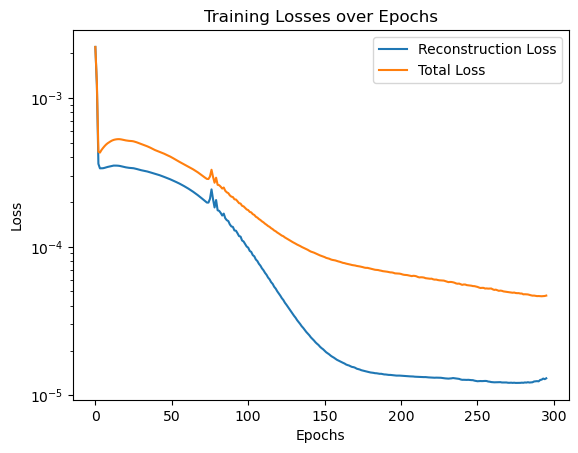

Final Reconstruction Loss: 0.000013, Final Sparsity Loss: 0.676922, Final Total Loss: 0.000047



Training with lambda = 5e-05 and lr = 0.003


 17%|█▋        | 169/1000 [00:41<03:24,  4.05it/s, loss=0.000040, recLoss=0.000021, spaLoss=0.382567]


Early stopping at epoch 170


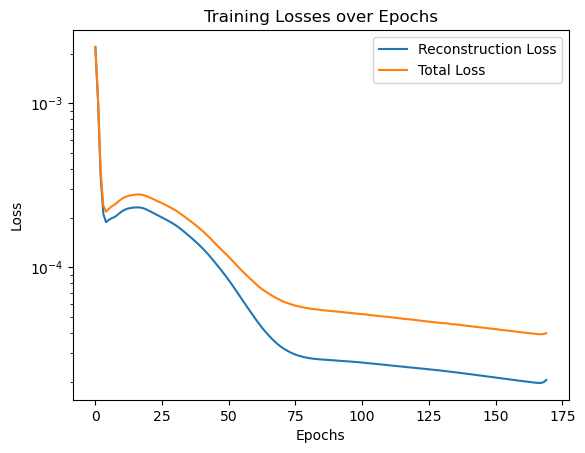

Final Reconstruction Loss: 0.000021, Final Sparsity Loss: 0.382567, Final Total Loss: 0.000040



Training with lambda = 5e-05 and lr = 0.001


 56%|█████▌    | 559/1000 [01:57<01:32,  4.76it/s, loss=0.000033, recLoss=0.000022, spaLoss=0.220775]


Early stopping at epoch 560


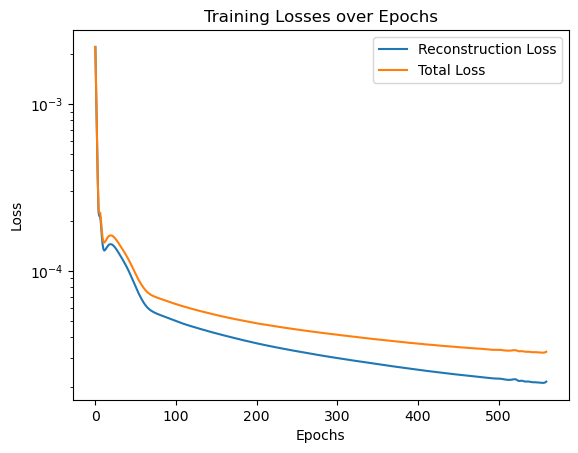

Final Reconstruction Loss: 0.000022, Final Sparsity Loss: 0.220775, Final Total Loss: 0.000033



Training with lambda = 5e-05 and lr = 0.0003


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s, loss=0.000037, recLoss=0.000027, spaLoss=0.212051]


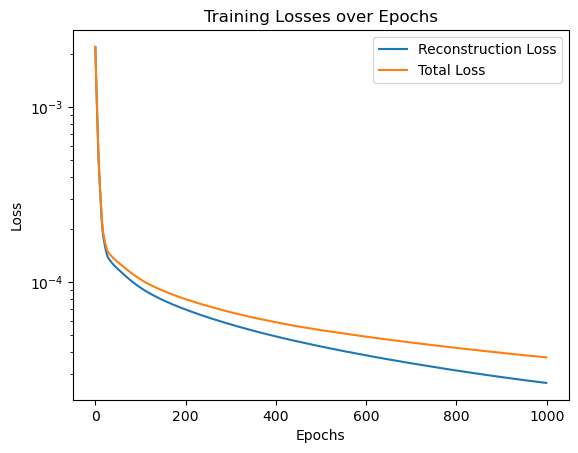

Final Reconstruction Loss: 0.000027, Final Sparsity Loss: 0.212051, Final Total Loss: 0.000037



Training with lambda = 0.0001 and lr = 0.01


 23%|██▎       | 229/1000 [01:05<03:40,  3.50it/s, loss=0.000065, recLoss=0.000013, spaLoss=0.522187]


Early stopping at epoch 230


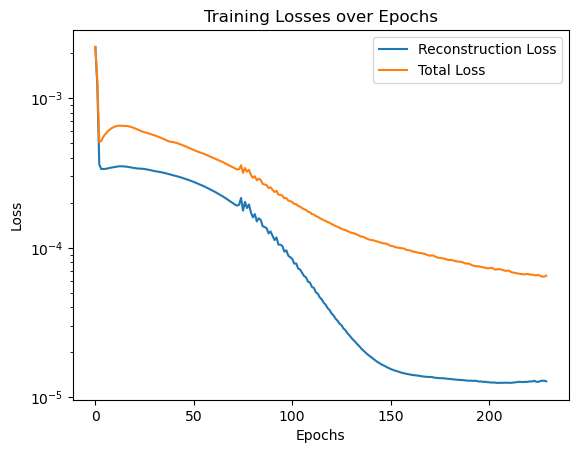

Final Reconstruction Loss: 0.000013, Final Sparsity Loss: 0.522187, Final Total Loss: 0.000065



Training with lambda = 0.0001 and lr = 0.003


 16%|█▌        | 160/1000 [00:34<03:00,  4.64it/s, loss=0.000049, recLoss=0.000023, spaLoss=0.266045]


Early stopping at epoch 161


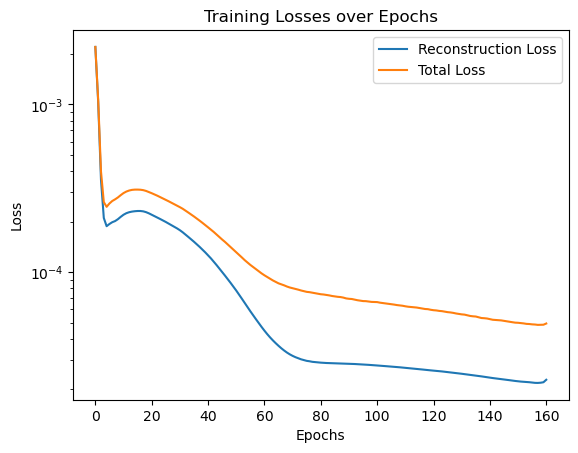

Final Reconstruction Loss: 0.000023, Final Sparsity Loss: 0.266045, Final Total Loss: 0.000049



Training with lambda = 0.0001 and lr = 0.001


 75%|███████▌  | 752/1000 [02:26<00:48,  5.12it/s, loss=0.000040, recLoss=0.000020, spaLoss=0.190980]


Early stopping at epoch 753


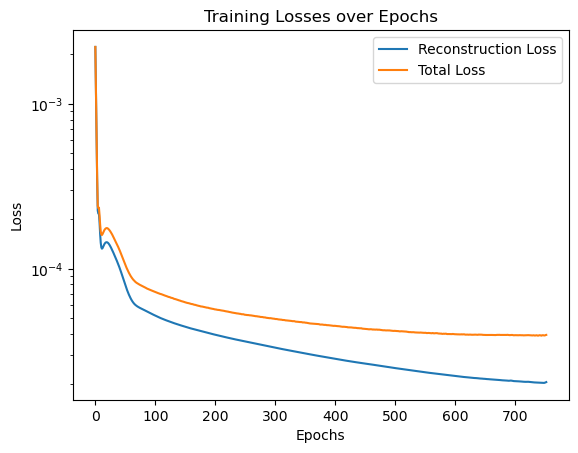

Final Reconstruction Loss: 0.000020, Final Sparsity Loss: 0.190980, Final Total Loss: 0.000040



Training with lambda = 0.0001 and lr = 0.0003


100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s, loss=0.000045, recLoss=0.000029, spaLoss=0.154543]


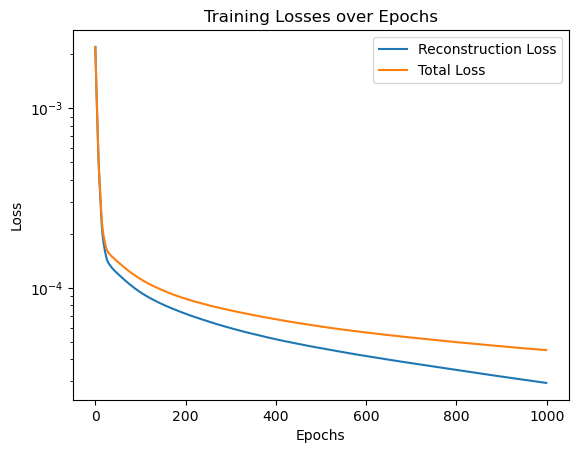

Final Reconstruction Loss: 0.000029, Final Sparsity Loss: 0.154543, Final Total Loss: 0.000045



Training with lambda = 0.0003 and lr = 0.01


 12%|█▏        | 115/1000 [00:40<05:12,  2.83it/s, loss=0.000182, recLoss=0.000025, spaLoss=0.520606]


Early stopping at epoch 116


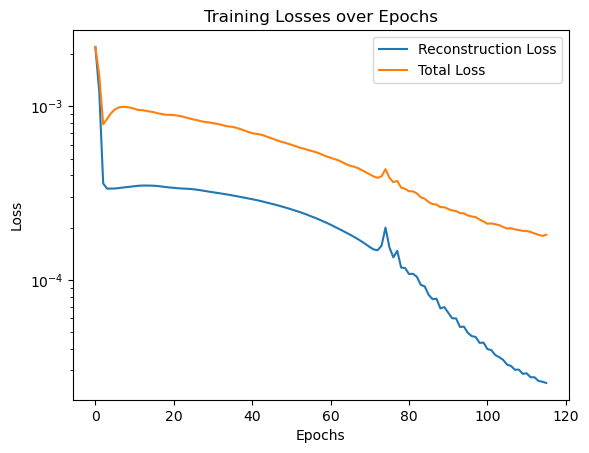

Final Reconstruction Loss: 0.000025, Final Sparsity Loss: 0.520606, Final Total Loss: 0.000182



Training with lambda = 0.0003 and lr = 0.003


 12%|█▏        | 120/1000 [00:25<03:05,  4.75it/s, loss=0.000080, recLoss=0.000031, spaLoss=0.160296]


Early stopping at epoch 121


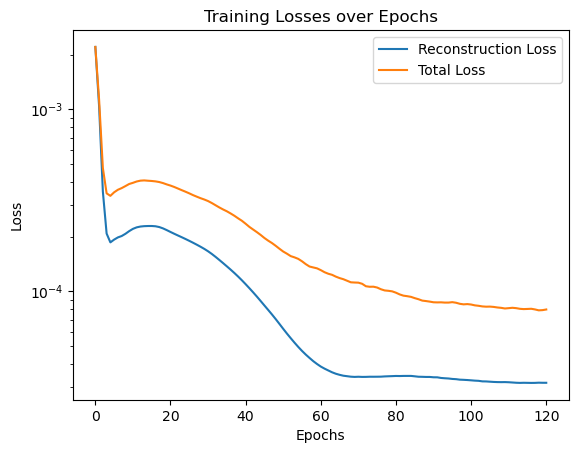

Final Reconstruction Loss: 0.000031, Final Sparsity Loss: 0.160296, Final Total Loss: 0.000080



Training with lambda = 0.0003 and lr = 0.001


 58%|█████▊    | 576/1000 [01:45<01:17,  5.44it/s, loss=0.000071, recLoss=0.000032, spaLoss=0.130458]


Early stopping at epoch 577


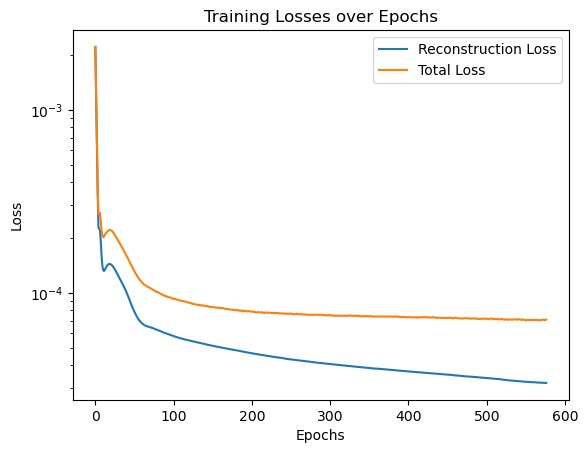

Final Reconstruction Loss: 0.000032, Final Sparsity Loss: 0.130458, Final Total Loss: 0.000071



Training with lambda = 0.0003 and lr = 0.0003


100%|██████████| 1000/1000 [02:45<00:00,  6.04it/s, loss=0.000072, recLoss=0.000037, spaLoss=0.113924]


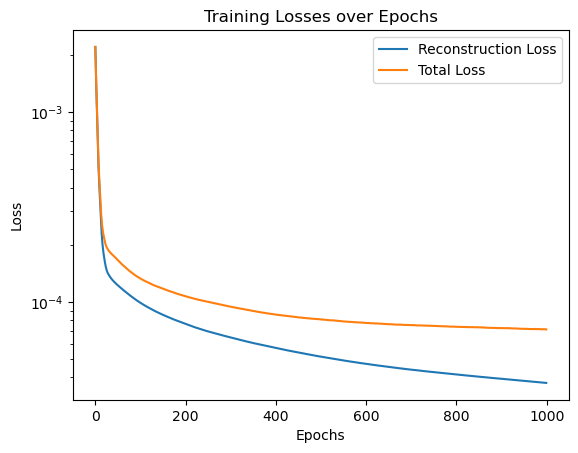

Final Reconstruction Loss: 0.000037, Final Sparsity Loss: 0.113924, Final Total Loss: 0.000072



Training with lambda = 0.001 and lr = 0.01


 11%|█         | 109/1000 [00:31<04:17,  3.46it/s, loss=0.000382, recLoss=0.000053, spaLoss=0.329116]


Early stopping at epoch 110


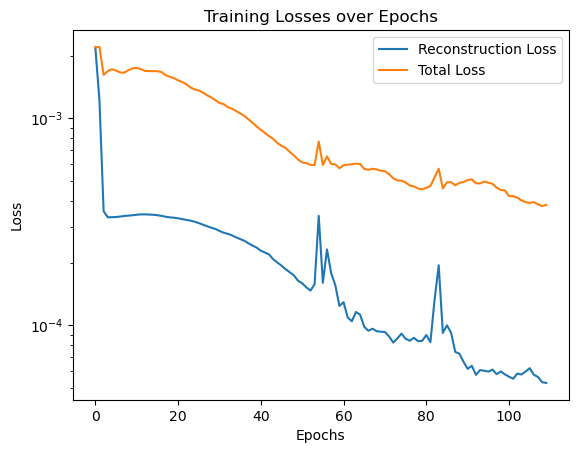

Final Reconstruction Loss: 0.000053, Final Sparsity Loss: 0.329116, Final Total Loss: 0.000382



Training with lambda = 0.001 and lr = 0.003


 11%|█         | 107/1000 [00:21<03:01,  4.93it/s, loss=0.000167, recLoss=0.000050, spaLoss=0.116268]


Early stopping at epoch 108


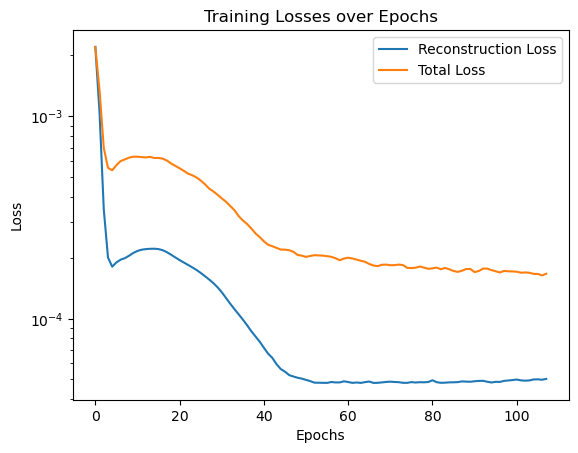

Final Reconstruction Loss: 0.000050, Final Sparsity Loss: 0.116268, Final Total Loss: 0.000167



Training with lambda = 0.001 and lr = 0.001


 12%|█▏        | 118/1000 [00:17<02:09,  6.83it/s, loss=0.000148, recLoss=0.000068, spaLoss=0.079668]


Early stopping at epoch 119


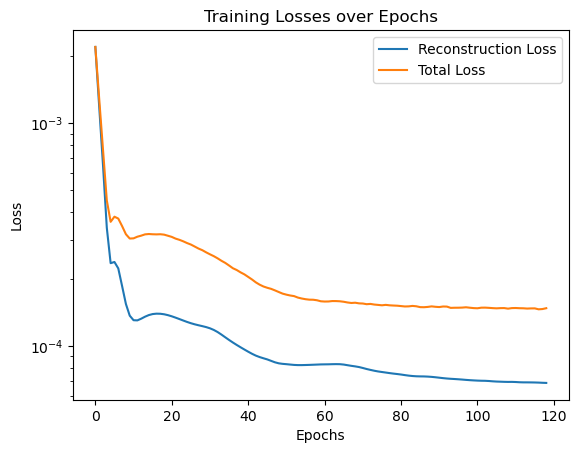

Final Reconstruction Loss: 0.000068, Final Sparsity Loss: 0.079668, Final Total Loss: 0.000148



Training with lambda = 0.001 and lr = 0.0003


100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s, loss=0.000138, recLoss=0.000063, spaLoss=0.075037]


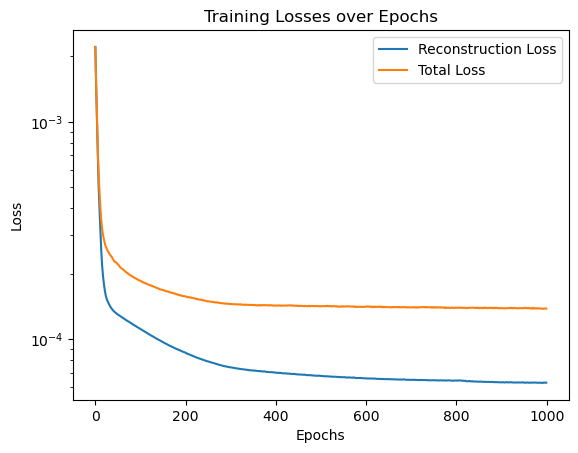

Final Reconstruction Loss: 0.000063, Final Sparsity Loss: 0.075037, Final Total Loss: 0.000138



Training with lambda = 0.01 and lr = 0.01


 10%|█         | 101/1000 [00:16<02:26,  6.12it/s, loss=0.001606, recLoss=0.000192, spaLoss=0.141452]


Early stopping at epoch 102


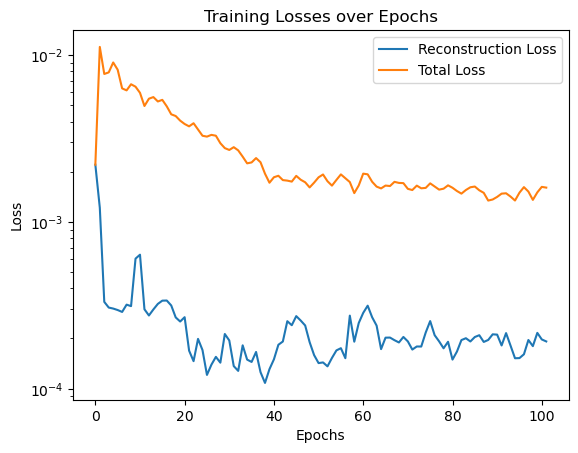

Final Reconstruction Loss: 0.000192, Final Sparsity Loss: 0.141452, Final Total Loss: 0.001606



Training with lambda = 0.01 and lr = 0.003


 10%|█         | 101/1000 [00:12<01:52,  7.96it/s, loss=0.000803, recLoss=0.000202, spaLoss=0.060050]


Early stopping at epoch 102


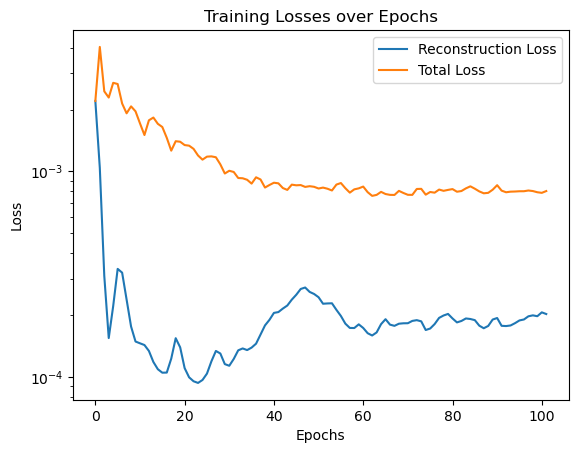

Final Reconstruction Loss: 0.000202, Final Sparsity Loss: 0.060050, Final Total Loss: 0.000803



Training with lambda = 0.01 and lr = 0.001


 10%|█         | 101/1000 [00:10<01:37,  9.22it/s, loss=0.000572, recLoss=0.000203, spaLoss=0.036851]


Early stopping at epoch 102


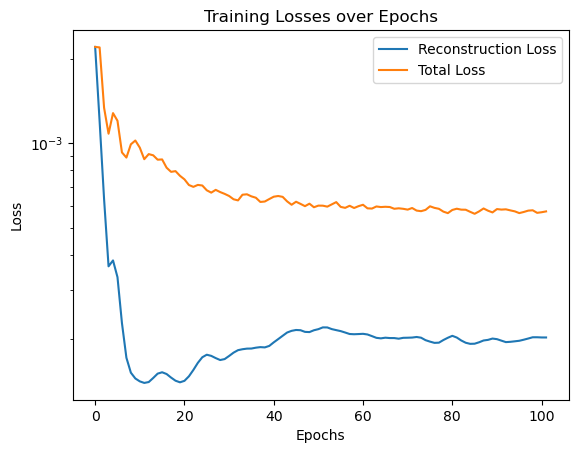

Final Reconstruction Loss: 0.000203, Final Sparsity Loss: 0.036851, Final Total Loss: 0.000572



Training with lambda = 0.01 and lr = 0.0003


 10%|█         | 105/1000 [00:09<01:21, 10.94it/s, loss=0.000536, recLoss=0.000210, spaLoss=0.032547]


Early stopping at epoch 106


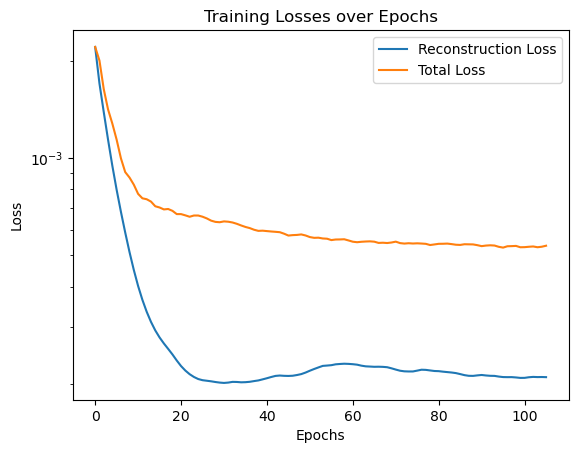

Final Reconstruction Loss: 0.000210, Final Sparsity Loss: 0.032547, Final Total Loss: 0.000536





In [ ]:
# lSparse   = 1e-4
# lr        = 1e-3
epochs    = 1000

coefs = [5e-5, 1e-4, 3e-4, 1e-3, 1e-2]
lr    = [1e-2, 3e-3, 1e-3, 3e-4]
rec, spa, sum = [], [], []

for coef in coefs:
    for learning_rate in lr:
        print(f"Training with lambda = {coef} and lr = {learning_rate}")
        ode, recLosses, spaLosses, sumLosses, _ = fitToData(trainX, tTrain, D, dim, lr = learning_rate, lambdaSparse = coef, epochs = epochs, init_grid_matrix = False, verbose = False, plotLoss = True, earlyStopping = True)
        rec.append(recLosses)
        spa.append(spaLosses)
        sum.append(sumLosses)
        print(f"Final Reconstruction Loss: {recLosses[-1]:.6f}, Final Sparsity Loss: {spaLosses[-1]:.6f}, Final Total Loss: {sumLosses[-1]:.6f}")
        print("\n\n")

In [19]:
# dataframe with all the final losses for each combination of coef and learning rate
final_losses = pd.DataFrame(columns = ['Lambda', 'Learning Rate', 'Final Reconstruction Loss', 'Final Sparsity Loss', 'Final Total Loss'])
index = 0
for i, coef in enumerate(coefs):
    for j, learning_rate in enumerate(lr):
        final_losses.loc[index] = [coef, learning_rate, rec[index][-1], spa[index][-1], sum[index][-1]]
        index += 1

final_losses

Lambda  Learning Rate  Final Reconstruction Loss  Final Sparsity Loss  \
0   0.00005         0.0100                   0.000013             0.676922   
1   0.00005         0.0030                   0.000021             0.382567   
2   0.00005         0.0010                   0.000022             0.220775   
3   0.00005         0.0003                   0.000027             0.212051   
4   0.00010         0.0100                   0.000013             0.522187   
5   0.00010         0.0030                   0.000023             0.266045   
6   0.00010         0.0010                   0.000020             0.190980   
7   0.00010         0.0003                   0.000029             0.154543   
8   0.00030         0.0100                   0.000025             0.520606   
9   0.00030         0.0030                   0.000031             0.160296   
10  0.00030         0.0010                   0.000032             0.130458   
11  0.00030         0.0003                   0.000037             0.113924   
12  0.00100         0.0100                   0.000053             0.329116   
13  0.00100         0.0030                   0.000050             0.116268   
14  0.00100         0.0010                   0.000068             0.079668   
15  0.00100         0.0003                   0.000063             0.075037   
16  0.01000         0.0100                   0.000192             0.141452   
17  0.01000         0.0030                   0.000202             0.060050   
18  0.01000         0.0010                   0.000203             0.036851   
19  0.01000         0.0003                   0.000210             0.032547   

    Final Total Loss  
0           0.000047  
1           0.000040  
2           0.000033  
3           0.000037  
4           0.000065  
5           0.000049  
6           0.000040  
7           0.000045  
8           0.000182  
9           0.000080  
10          0.000071  
11          0.000072  
12          0.000382  
13          0.000167  
14          0.000148  
15          0.000138  
16          0.001606  
17          0.000803  
18          0.000572  
19          0.000536

looks (lambda, lr) = (0.00010, 0.001) - with index = 6 - achieves the best balance of sparsity vs model loss

In [47]:
learning_rate, coef = 0.001, 0.0001
epochs    = 1000

# if the file "models/odeModel.pkl" exists, load the model from there
from pathlib import Path
if Path("models/odeModel.pkl").exists():
    with open("models/odeModel.pkl", "rb") as f:
        ode = torch.load(f, weights_only = False)
else:
    ode = fitToData(trainX, tTrain, D, dim, lr = learning_rate, lambdaSparse = coef, epochs = epochs, init_grid_matrix = False, verbose = False, plotLoss = True, earlyStopping = True)[0]
    with open("models/odeModel.pkl", "wb") as f:
        torch.save(ode, f)
    

In [81]:
def plotFit(data, times, model, threshold = None, includeExcluded = False):
    with torch.no_grad():
        if threshold is not None:
            w = ode.linear.weight.data
            threshW  = (torch.abs(w) > threshold) * w
            newModel = ODE(D, dim = dim)
            newModel.linear.weight.data = threshW
            predX    = odeint(newModel, data[0], times - times[0])
        else:
            predX    = odeint(model, data[0], times - times[0])

        df_out = pd.DataFrame(predX, index = times.numpy(), columns = df.columns)
        df_out_long = df_out.reset_index().melt(id_vars = 'index')

        # plot a separate graph of the solution + scatter points for each variable
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(3, 4, hspace = 0.5, wspace = 0.5)
        
        ax = [
            fig.add_subplot(gs[0, :2]),   # Top left
            fig.add_subplot(gs[0, 2:]),   # Top right
            fig.add_subplot(gs[1, :2]),   # Middle left
            fig.add_subplot(gs[1, 2:]),   # Middle right
            fig.add_subplot(gs[2, 1:3])   # Bottom center
        ]

        for i, d in enumerate(df.columns):
            sns.lineplot(data = df_out_long[df_out_long['variable'] == d], x = 'index', y = 'value', ax = ax[i])
            ax[i].scatter(times.numpy(), df[d].loc[times.numpy().astype(int)], s = 10, color = 'red')
            if includeExcluded:
                # plot the excluded time points in a different color
                excluded = df.index.difference(times.numpy().astype(int))
                ax[i].scatter(excluded, df[d].loc[excluded], s = 10, color = 'orange')
            ax[i].set_title(f'Solution for variable {d}')
            ax[i].set_xlabel('Time')
            ax[i].set_ylabel(d)
            # plot the axis
            ax[i].hlines(y = 0, xmin = df.index.values[0], xmax = df.index.values[-1], color = 'k', linestyle = '--', linewidth = 0.5)
            ax[i].vlines(x = 0, ymin = df_out_long['value'].min(), ymax = df_out_long['value'].max(), color = 'k', linestyle = '--', linewidth = 0.5)
            # show the grid
            ax[i].grid(True)
            # set ticks = times
            ax[i].set_xticks(times.numpy())
        
        plt.tight_layout()
        plt.show()

    return predX

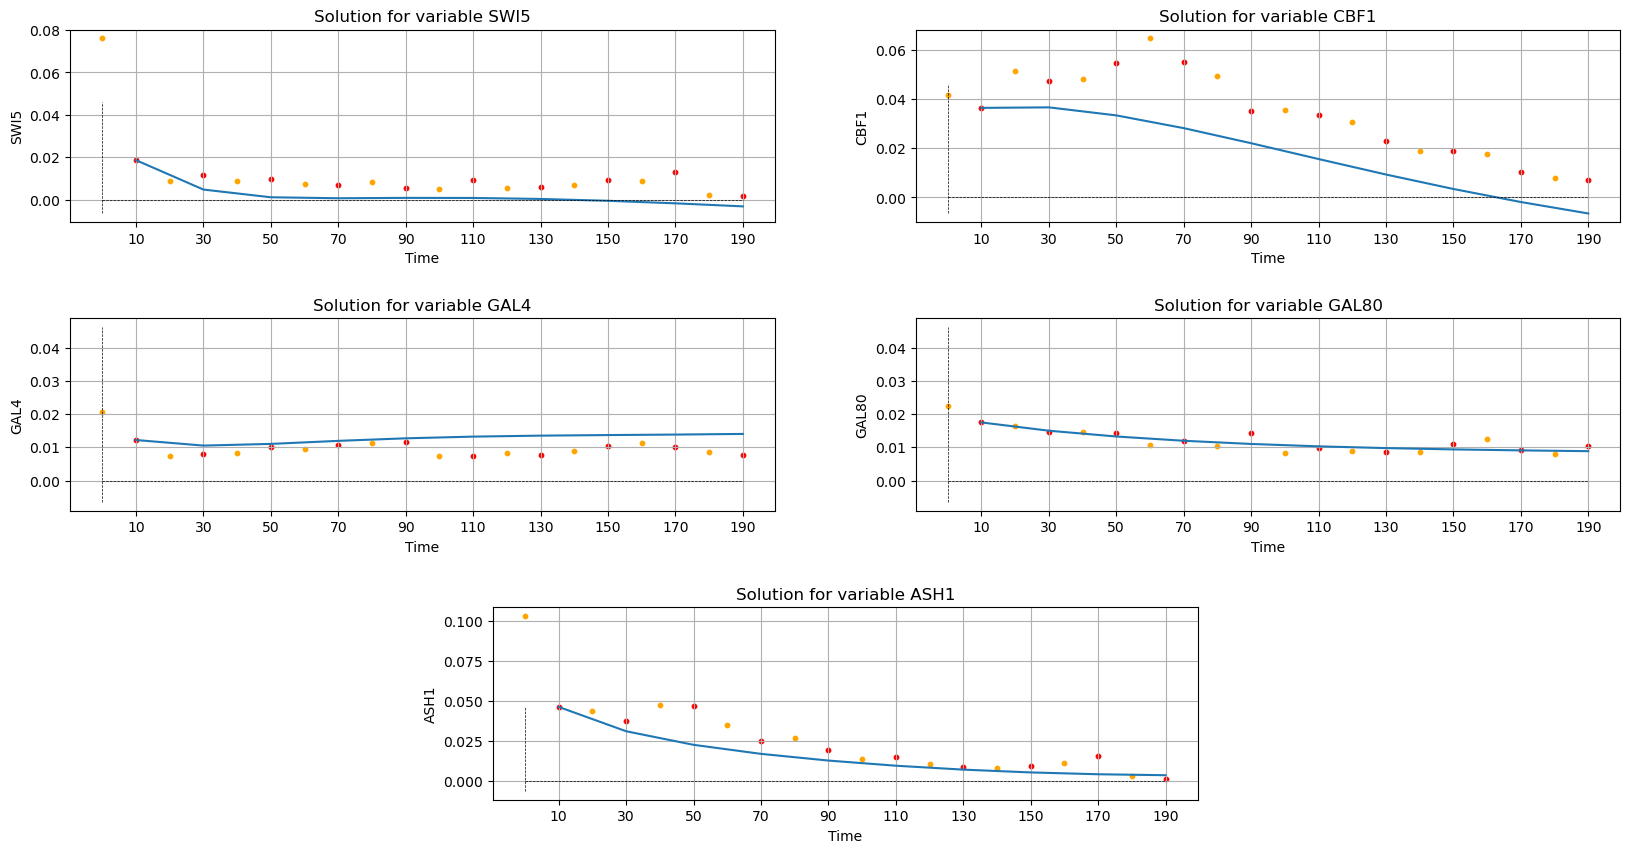

tensor([[ 0.0186,  0.0365,  0.0122,  0.0175,  0.0462],
        [ 0.0047,  0.0367,  0.0105,  0.0150,  0.0309],
        [ 0.0011,  0.0334,  0.0110,  0.0133,  0.0224],
        [ 0.0006,  0.0282,  0.0119,  0.0120,  0.0167],
        [ 0.0008,  0.0221,  0.0127,  0.0110,  0.0125],
        [ 0.0008,  0.0156,  0.0132,  0.0103,  0.0093],
        [ 0.0003,  0.0093,  0.0135,  0.0098,  0.0069],
        [-0.0006,  0.0034,  0.0137,  0.0094,  0.0051],
        [-0.0018, -0.0019,  0.0138,  0.0091,  0.0039],
        [-0.0032, -0.0065,  0.0140,  0.0088,  0.0033]])

In [82]:
plotFit(testX, tTest, ode, threshold = 1e-3, includeExcluded = True)

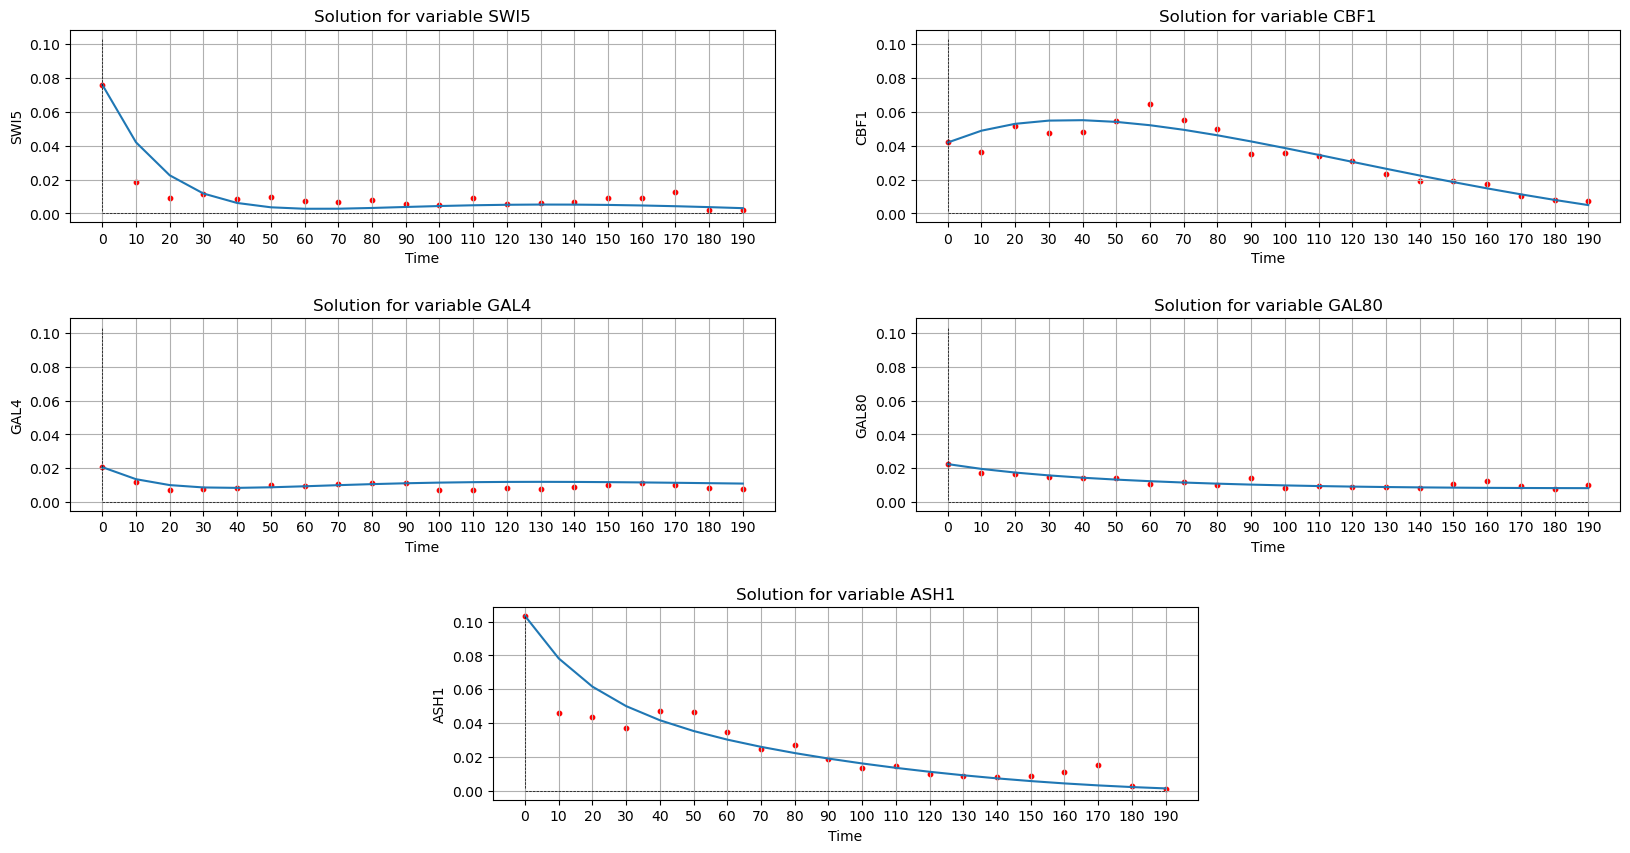

In [83]:
predX = plotFit(baselineX, t, ode)

In [80]:
((predX[1::2] - testX)**2).sum(), ((predX[::2] - trainX)**2).sum(), ((predX[1::2] - testX)**2).sum() /  ((predX[::2] - trainX)**2).sum(), ((predX - baselineX)**2).sum()

(tensor(0.0026), tensor(0.0010), tensor(2.5212), tensor(0.0036))

### Making a structure out of the model

In [89]:
def makeGraph(model, threshold = 1e-3, verbose = False, plotGraph = True, sideBySide = False):
    w     = model.linear.weight.data.numpy().copy()
    graph = nx.DiGraph()
    
    w[np.abs(w) < threshold] = 0

    for i, var in enumerate(model.varNames):
        if verbose:
            print(f"d{var}/dt = ", end="")
        coefs = w[i]
        firstTerm = True
        for term, coef in zip(ode.libTerms, coefs):
            if coef != 0:
                if '^' in term:
                    termStr = [term.split('^')[0]]
                elif '*' in term:
                    termStr = set(term.split(' * '))
                else:
                    termStr = [term]

                for ts in termStr:
                    graph.add_edge(ts, var, weight = coef)
                if verbose:
                    if firstTerm:
                        print(f"{coef:.3f} * {term}", end="")
                        firstTerm = False
                    else:
                        if coef < 0:
                            print(" - ", end="")
                            print(f"{-coef:.3f} * {term}", end="")
                        else:
                            print(" + ", end="")
                            print(f"{coef:.3f} * {term}", end="")
        if verbose: print()

    if plotGraph and not sideBySide:
        fig, ax = plt.subplots(figsize = (12, 9))
        nx.draw(graph, POS, with_labels = True, node_size = 700, node_color = 'lightgreen', font_size = 10, font_weight = 'bold', edge_color = 'gray', ax = ax)
        plt.show()
    elif plotGraph and sideBySide:
        fig, ax = plt.subplots(1, 2, figsize = (12, 4))
        nx.draw(graph,   POS, with_labels = True, node_size = 700, node_color = 'lightgreen', font_size = 10, font_weight = 'bold', edge_color = 'gray', ax = ax[0])
        nx.draw(REF_NET, POS, with_labels = True, node_size = 700, node_color = 'lightcoral', font_size = 10, font_weight = 'bold', edge_color = 'gray', ax = ax[1])
        # set titles
        ax[0].set_title('Learned Network')
        ax[1].set_title('Reference Network')
        plt.show()
    
    return graph

dSWI5/dt = -0.033 * SWI5 + 0.015 * CBF1 - 0.024 * ASH1
dCBF1/dt = -0.010 * CBF1 - 0.024 * GAL4 + 0.018 * ASH1
dGAL4/dt = -0.012 * SWI5
dGAL80/dt = -0.003 * ASH1
dASH1/dt = -0.018 * SWI5 - 0.018 * ASH1


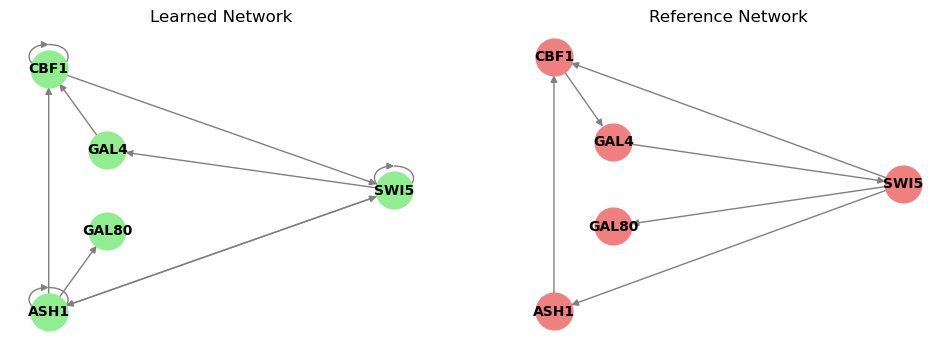

True Positives: 	2 
False Negatives: 	4 
False Positives: 	8 
Precision: 		0.20 
Recall: 		0.33


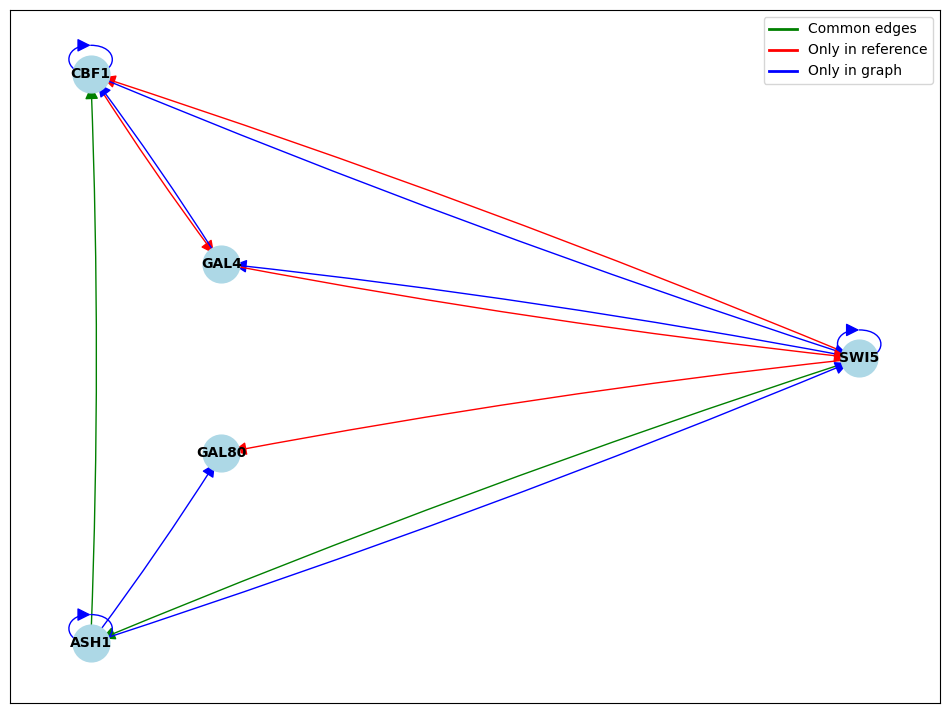

In [157]:
graph = makeGraph(ode, threshold = 30 * 1e-4, verbose = True, plotGraph = True, sideBySide = True)
highlight_edges(graph, REF_NET)

Weights shape: (5, 5)
Cluster 0: min = 3.3107062336057425e-07, max = 0.003308, size = 16
Cluster 1: min = 0.010357469320297241, max = 0.017780, size = 6
Cluster 2: min = 0.024386564269661903, max = 0.033217, size = 3


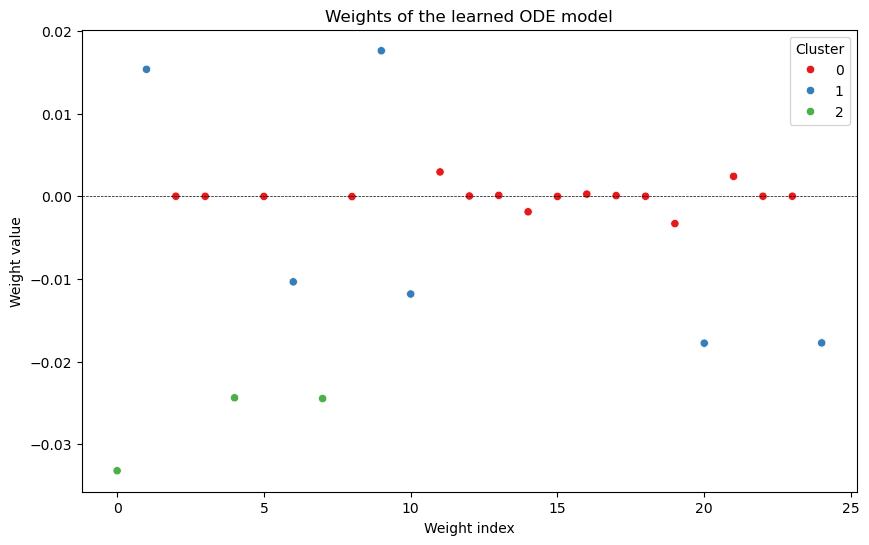

In [137]:
w = ode.linear.weight.data.numpy().copy()[:, :5]
print("Weights shape:", w.shape)
# cluster the weights by absolute value
from sklearn.cluster import KMeans
abs_w = np.abs(w).reshape(-1, 1)
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(abs_w)
clusters = kmeans.labels_.reshape(w.shape)
# print intervals for each cluster
for i in range(3):
    cluster_weights = abs_w[kmeans.labels_ == i]
    print(f"Cluster {i}: min = {cluster_weights.min()}, max = {cluster_weights.max():.6f}, size = {cluster_weights.size}")

# plot the weights on the x-axis
plt.figure(figsize = (10, 6))
sns.scatterplot(x = range(w.size), y = w.flatten(), hue = clusters.flatten(), palette = 'Set1')
plt.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5)
plt.title('Weights of the learned ODE model')
plt.xlabel('Weight index')
plt.ylabel('Weight value')
plt.legend(title = 'Cluster')
plt.show()

##### Sanity check: trying out the model with learning_rate, coef = 0.01, 0.0001

 75%|███████▌  | 752/1000 [00:50<00:16, 14.79it/s, loss=0.000040, recLoss=0.000020, spaLoss=0.191018]


Early stopping at epoch 753


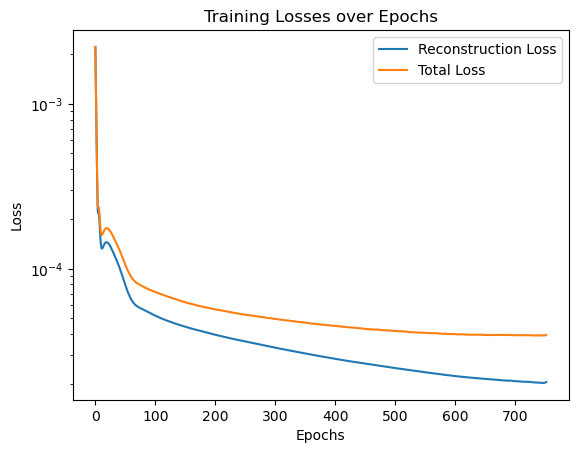

In [158]:
ode2 = fitToData(trainX, tTrain, D, dim, lr = learning_rate, lambdaSparse = coef, epochs = epochs, init_grid_matrix = False, verbose = False, plotLoss = True, earlyStopping = True)[0]

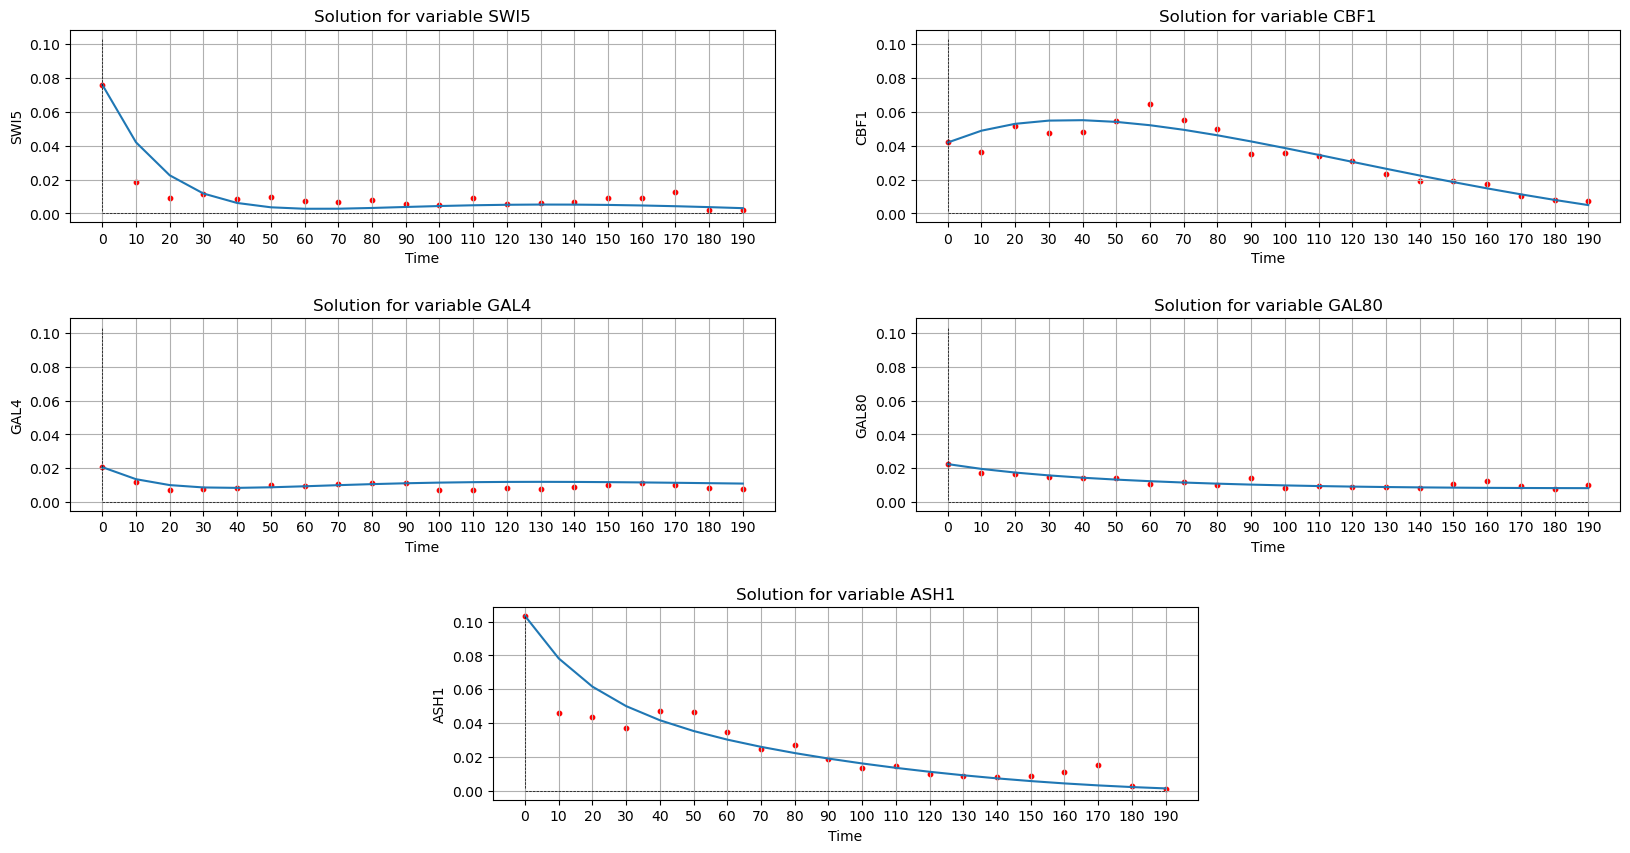

tensor([[0.0760, 0.0419, 0.0207, 0.0225, 0.1033],
        [0.0420, 0.0489, 0.0136, 0.0197, 0.0782],
        [0.0225, 0.0529, 0.0101, 0.0175, 0.0616],
        [0.0118, 0.0548, 0.0087, 0.0158, 0.0501],
        [0.0062, 0.0551, 0.0085, 0.0145, 0.0418],
        [0.0036, 0.0541, 0.0088, 0.0133, 0.0354],
        [0.0028, 0.0521, 0.0094, 0.0124, 0.0303],
        [0.0028, 0.0494, 0.0101, 0.0116, 0.0261],
        [0.0033, 0.0461, 0.0107, 0.0110, 0.0224],
        [0.0038, 0.0425, 0.0112, 0.0104, 0.0191],
        [0.0044, 0.0386, 0.0116, 0.0099, 0.0162],
        [0.0048, 0.0346, 0.0118, 0.0095, 0.0137],
        [0.0051, 0.0305, 0.0120, 0.0092, 0.0113],
        [0.0053, 0.0264, 0.0120, 0.0090, 0.0093],
        [0.0052, 0.0224, 0.0120, 0.0088, 0.0074],
        [0.0050, 0.0185, 0.0119, 0.0086, 0.0058],
        [0.0047, 0.0148, 0.0117, 0.0085, 0.0045],
        [0.0043, 0.0113, 0.0115, 0.0084, 0.0033],
        [0.0038, 0.0080, 0.0112, 0.0083, 0.0023],
        [0.0031, 0.0049, 0.0110, 0.0083, 0.0015]])

In [162]:
plotFit(baselineX, t, ode2)

dSWI5/dt = -0.033 * SWI5 + 0.015 * CBF1 - 0.024 * ASH1
dCBF1/dt = -0.010 * CBF1 - 0.024 * GAL4 + 0.018 * ASH1
dGAL4/dt = -0.012 * SWI5 + 0.003 * CBF1
dGAL80/dt = -0.003 * ASH1
dASH1/dt = -0.018 * SWI5 - 0.018 * ASH1


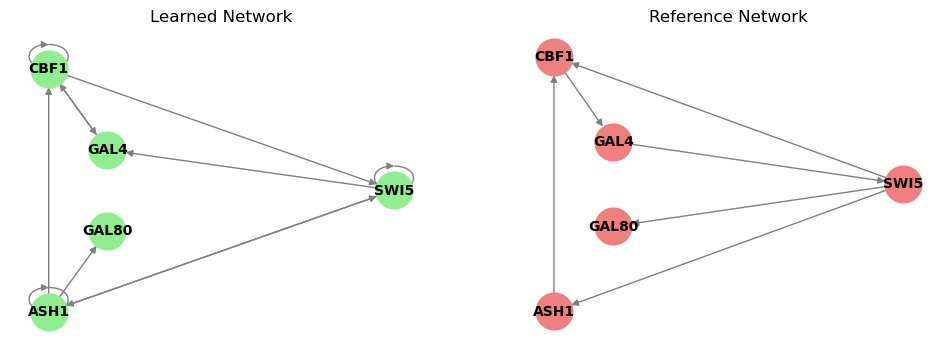

In [167]:
graph2 = makeGraph(ode2, threshold = 2.5e-3, verbose = True, plotGraph = True, sideBySide = True)

True Positives: 	3 
False Negatives: 	3 
False Positives: 	8 
Precision: 		0.27 
Recall: 		0.50


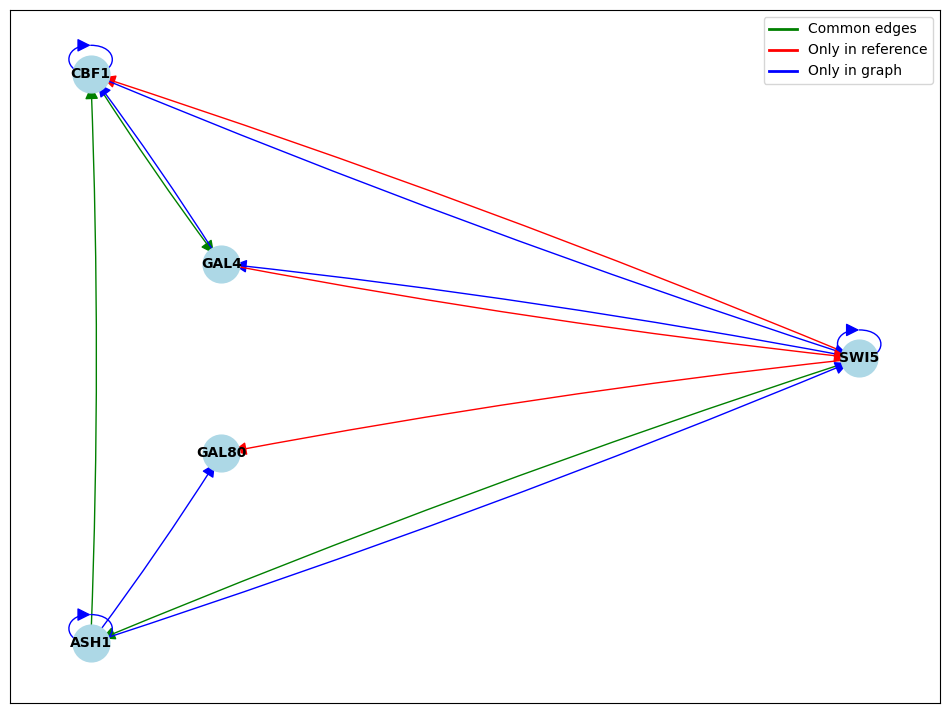

In [168]:
highlight_edges(graph2, REF_NET)

### Can I make it work in 3 dimensions?

 47%|████▋     | 472/1000 [00:54<01:00,  8.68it/s, loss=0.000045, recLoss=0.000026, spaLoss=0.188691]


Early stopping at epoch 473


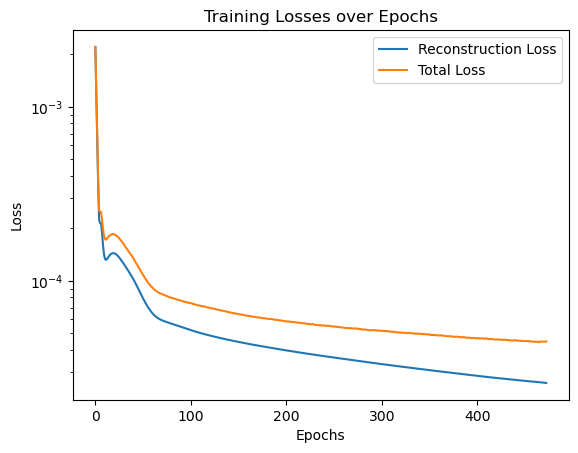

In [169]:
m = 3
learning_rate, coef = 0.001, 0.0001

ode = fitToData(trainX, tTrain, D, m, lr = learning_rate, lambdaSparse = coef, epochs = epochs, init_grid_matrix = False, verbose = False, plotLoss = True, earlyStopping = True)[0]

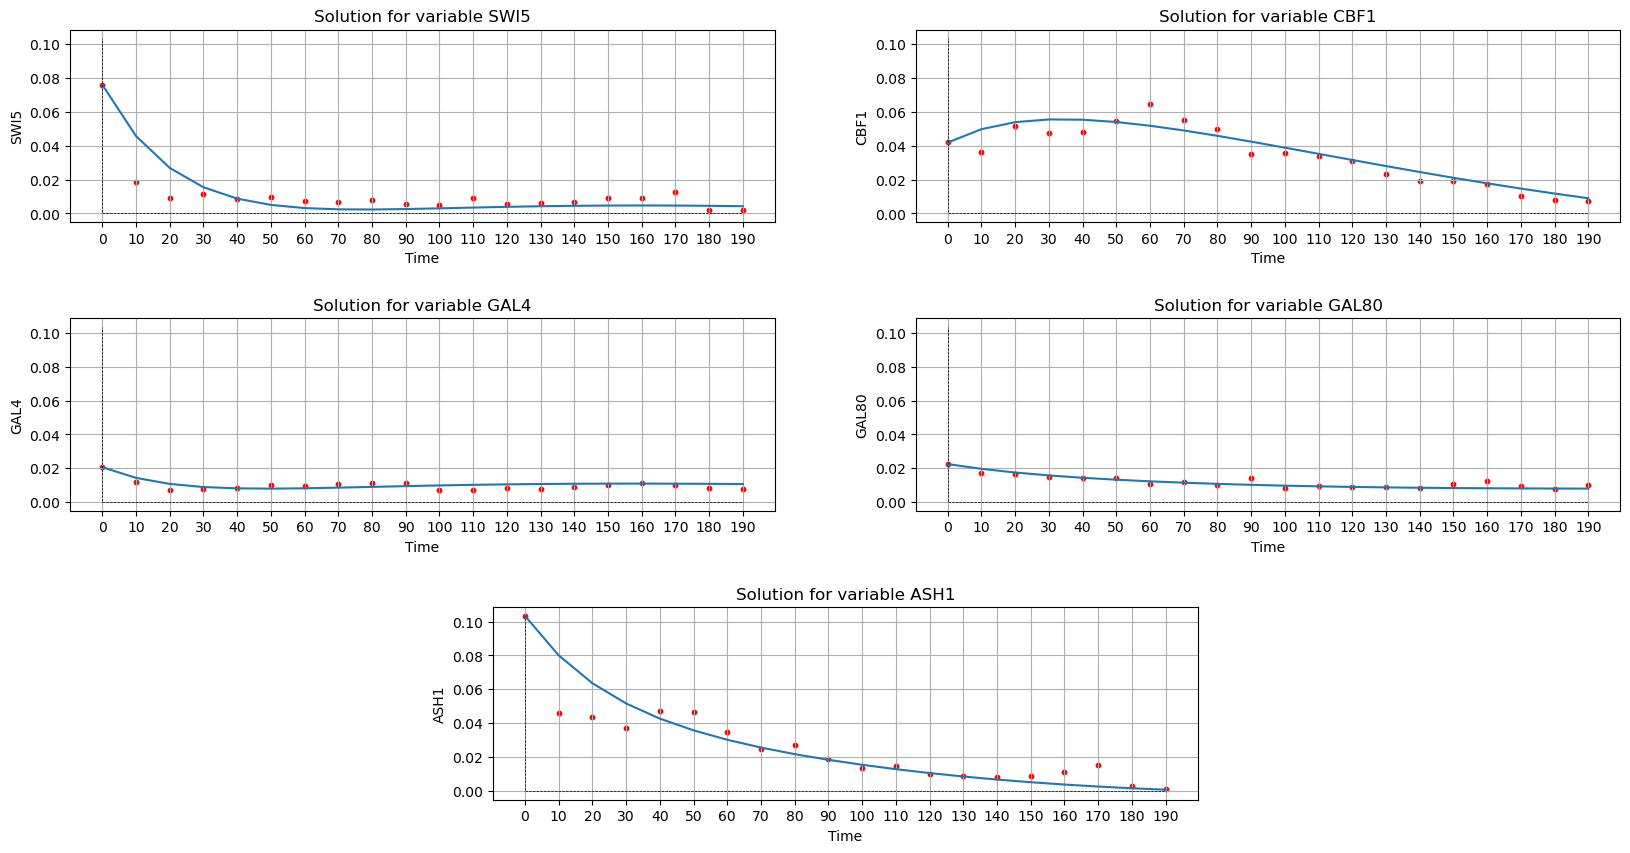

tensor([[0.0760, 0.0419, 0.0207, 0.0225, 0.1033],
        [0.0457, 0.0498, 0.0144, 0.0197, 0.0800],
        [0.0269, 0.0539, 0.0108, 0.0175, 0.0636],
        [0.0155, 0.0555, 0.0090, 0.0158, 0.0517],
        [0.0088, 0.0554, 0.0082, 0.0144, 0.0427],
        [0.0051, 0.0540, 0.0080, 0.0133, 0.0358],
        [0.0032, 0.0518, 0.0082, 0.0123, 0.0302],
        [0.0024, 0.0490, 0.0086, 0.0115, 0.0256],
        [0.0023, 0.0458, 0.0091, 0.0108, 0.0217],
        [0.0026, 0.0424, 0.0095, 0.0103, 0.0184],
        [0.0030, 0.0388, 0.0099, 0.0098, 0.0155],
        [0.0035, 0.0352, 0.0103, 0.0094, 0.0129],
        [0.0039, 0.0316, 0.0105, 0.0090, 0.0106],
        [0.0043, 0.0280, 0.0108, 0.0088, 0.0085],
        [0.0045, 0.0245, 0.0109, 0.0085, 0.0067],
        [0.0047, 0.0211, 0.0110, 0.0084, 0.0052],
        [0.0047, 0.0178, 0.0110, 0.0082, 0.0038],
        [0.0047, 0.0147, 0.0109, 0.0081, 0.0026],
        [0.0045, 0.0118, 0.0109, 0.0081, 0.0016],
        [0.0043, 0.0090, 0.0107, 0.0080, 0.0008]])

In [170]:
plotFit(baselineX, t, ode)